In [ ]:
from jax import jit, random, grad
import jax.numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import optax

# Testing random code

In [ ]:
# Structure constants in matrix
c = jnp.array([
    [[0,0,0],
     [0,-1,2],
     [0,0,-1]],

    [[0,1,-2],
     [0,0,0],
     [0,0,0]],

    [[0,0,1],
     [0,0,0],
     [0,0,0]]
])

# Gives error if c is anti-symmetric
assert jnp.all(c == -c.transpose((1,0,2)))

# Use key to generate random values for initial guess
key = random.key(0)
B_init = random.normal(key, (3,3), dtype=jnp.float32)

In [ ]:
B_init

Array([[-0.3721109 ,  0.26423115, -0.18252768],
       [-0.7368197 ,  0.44973662, -0.1521442 ],
       [-0.67135346, -0.5908641 ,  0.73168886]], dtype=float32)

In [ ]:
# does ??? (3,3,3)
res = np.einsum("nij", c)
res

# trace
res = np.einsum("ii", B_init)
res

# sum of all elements for each matrix c^n (1x3)
res3 = np.einsum("nij->n",c)
res3

# sum of all element for each specific location  (3x3)
# Note that order of "ij" after arrow does matter for placements
res4 = np.einsum("nij->ij", c)
res4

# sum of all rows over all matrices for a specific column (1x3)
res = np.einsum("nij->j", c)
res

# sum of all columns over all matrices for a specific row (1x3)
# same as sum_n sum_i c^n_ij = a_j
res = np.einsum("nij->i", c)
res

array([ 0,  1, -1], dtype=int32)

In [ ]:
# Create temp matrix for testing purposes
D = np.arange(1, 10).reshape(3,3)
print(D)

res2 = np.einsum("nij,nk", c, D)
res2

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[[ 0,  0,  0],
        [ 4,  5,  6],
        [-1, -2, -3]],

       [[ 0,  0,  0],
        [-1, -2, -3],
        [ 2,  4,  6]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [-1, -2, -3]]])

In [ ]:
# attempt to write out rhs of conditions
rhs = np.einsum("jik,kn->jin", c, D)
rhs
# for einsum, order is matrix, row, column
# Hydon paper c^k_ij gives n column, i row, j matrix. Therefore c^k_ij has einsum order "jik",
# and then we can follow the summations as done in Hydon.
# For a specific i,j,n the rhs value can be found in matrix j, row i, column n

# Using this notation, we can find the corresponding value of nij at matrix n, row i, column j
rhs = np.einsum("jik,kn->nij",c,D)
rhs

array([[[  0, -10,   7],
        [ 10,   0,   0],
        [ -7,   0,   0]],

       [[  0, -11,   8],
        [ 11,   0,   0],
        [ -8,   0,   0]],

       [[  0, -12,   9],
        [ 12,   0,   0],
        [ -9,   0,   0]]])

In [ ]:
# attempt to write out lhs of conditions
lhs = np.einsum("mln,il,jm->nij",c,D,D)
lhs

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0, -3, -6],
        [ 3,  0, -3],
        [ 6,  3,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]])

In [ ]:
# Checking if conditions from Jelle AI give same results
# lhs = jnp.dot(jnp.dot(c, D), D.T)
# print(lhs)
# rhs = jnp.dot(D, jnp.dot(c, D.T))
# print(rhs)

# Results are clearly different from using einsum, hence do not use these.

In [ ]:
# Testing if we can implement determinant condition using sums and checking if they are close to 0
Z = np.array([[0, 0, 0.01],
              [1,2,3],
              [-1.01, 3, 4]])
tol = 1e-5

col_sums = jnp.einsum("nk->k", Z)
row_sums = jnp.einsum("nk->n", Z)

vals = np.isclose(col_sums, 0, atol=tol)
ans = (vals==True).any()
ans

True
0


In [ ]:
# condition on B
def condition_on_B(B):
  lhs = np.einsum("mln,il,jm->nij",c,B,B)
  rhs = np.einsum("jik,kn->nij",c,B)
  return lhs - rhs

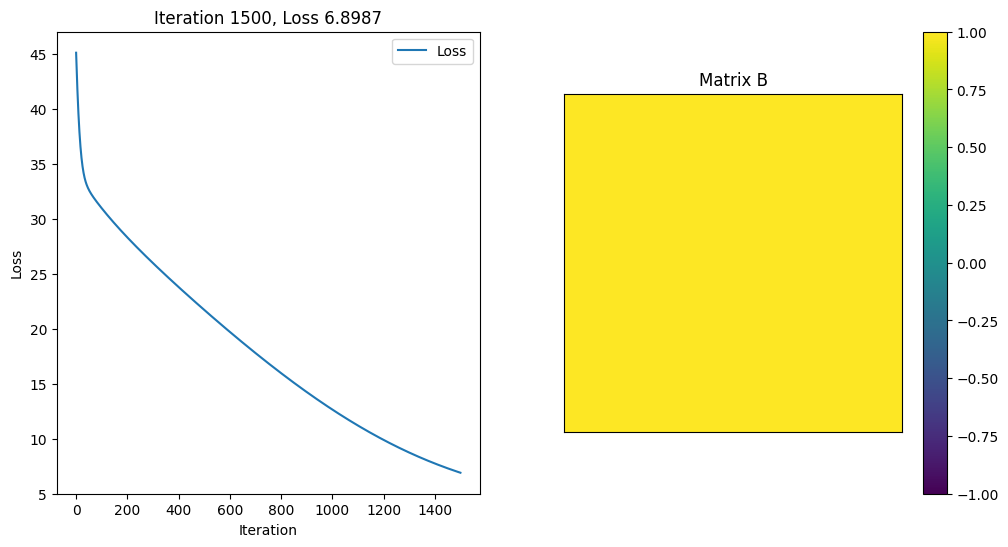

Current B at iteration 1500:
[[2.08887   2.518988  2.6161509]
 [4.8103294 6.353838  7.5509896]
 [2.2330253 3.0609937 3.9692528]]


KeyboardInterrupt: 

In [ ]:
# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c,B,B)
  rhs = jnp.einsum("jik,kn->nij",c,B)
  return lhs - rhs

"""
def zero_determinant(B, tol):
  col_sums = jnp.einsum("nk->k", B)
  row_sums = jnp.einsum("nk->n", B)
  all_sums = jnp.concatenate((col_sums, row_sums), axis=None)

  # array of booleans whether
  close_booleans = jnp.isclose(all_sums, 0, atol=tol)
  ans = (close_booleans==True).any()
  if ans == True:
    return 1
  else:
    return 0
"""

def determinant(B):
  return jnp.linalg.det(B)

def zero_determinant(B, tol):
  det = determinant(B)
  if abs(det) < tol:
    return 1
  else:
    return 0

# loss function to be optimized, using frobenius norm
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-5)

# Use the grad function from jax
grad_loss = grad(loss)

# Now optimize this with a gradient descent loop to find B
# Keep track of the loss

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 2e-3
iterations = 12_000
update_frequency = 300

# Perform gradient descent with periodic updates
# B = B_init
B = jnp.arange(1, 10).reshape(3,3) + B_init
loss_values = []
for i in range(iterations):
    # Compute gradient
    gradients = grad_loss(B)

    # Update B
    B -= learning_rate * gradients

    # Compute and track loss
    current_loss = loss(B)
    loss_values.append(current_loss)

    # Update plot and show matrix B every 100 iterations
    if (i + 1) % update_frequency == 0 or i == 0:
        clear_output(wait=True)

        # Plotting the loss
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(loss_values, label='Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

        # Showing the matrix B
        plt.subplot(1, 2, 2)
        plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title('Matrix B')
        plt.xticks([])
        plt.yticks([])

        display(plt.gcf())
        plt.close()

        # Printing the current matrix B
        print(f'Current B at iteration {i+1}:\n{B}')

# Ch 2. Finding B Matrix Spherical Burgers Eq

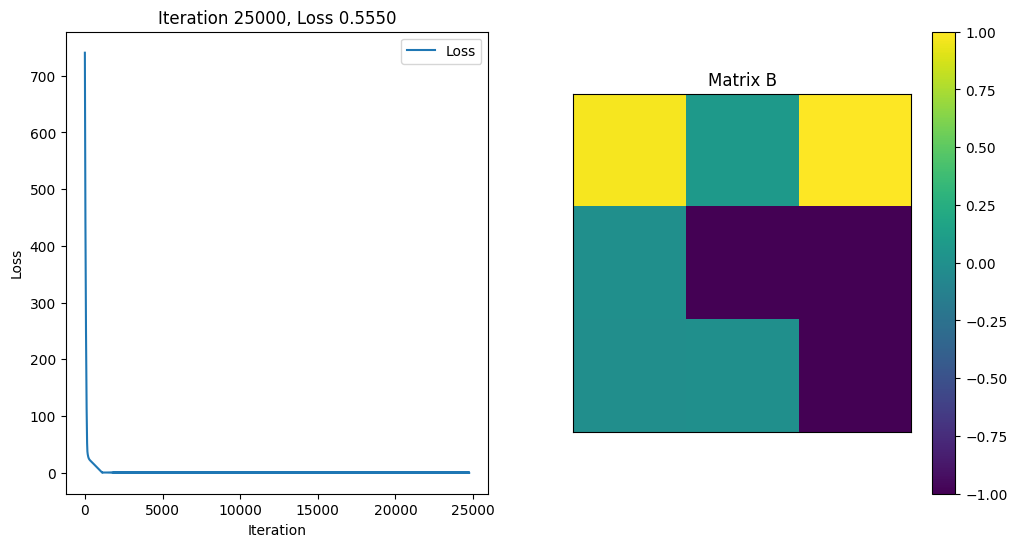

Current B at iteration 25000:
[[ 9.7283125e-01  8.3908357e-02  3.4677324e+00]
 [-2.2355898e-06 -9.2530518e+00 -1.8669216e+01]
 [-1.0193003e-02 -9.7818498e-04 -9.2529392e+00]]


In [ ]:
# Testing
# Use key to generate random values for initial guess
key = random.key(3)
B_init = 10*random.normal(key, (3,3), dtype=jnp.float32)

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c,B,B)
  rhs = jnp.einsum("jik,kn->nij",c,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-5)

# Use the grad function from jax
grad_loss = jit(grad(loss))

# Now optimize this with a gradient descent loop to find B
# Keep track of the loss

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 2e-3
iterations = 25_000
update_frequency = 1000

# Perform gradient descent with periodic updates
B = B_init
loss_values = []
for i in range(iterations):
    # Compute gradient
    gradient = grad_loss(B)

    # Update B
    B -= learning_rate * gradient

    # Compute and track loss
    current_loss = loss(B)
    if (i+1) % 100 or i == 0:
      loss_values.append(current_loss)

    # Update plot and show matrix B every 100 iterations
    if (i + 1) % update_frequency == 0 or i == 0:
        clear_output(wait=True)

        # Plotting the loss
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(loss_values, label='Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

        # Showing the matrix B
        plt.subplot(1, 2, 2)
        plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title('Matrix B')
        plt.xticks([])
        plt.yticks([])

        display(plt.gcf())
        plt.close()

        # Printing the current matrix B
        print(f'Current B at iteration {i+1}:\n{B}')

# Ch 3. Heat Equation Discrete Symmetries <br>
6 generators, 2 possible B matrix configurations. Will it find both or just one? Use same structure constants and numbering of generators as R. J. Gray

In [ ]:
# Construct structure constant matrices, only do [vi, vj] where i < j
c_heat = jnp.zeros((6,6,6))

c_heat = c_heat.at[3, 0, 0].set(1)
c_heat = c_heat.at[4, 3, 4].set(1)
c_heat = c_heat.at[4,0,2].set(-1)

c_heat = c_heat.at[5,0,4].set(2)
c_heat = c_heat.at[3,1,1].set(2)
c_heat = c_heat.at[4,1,0].set(2)
c_heat = c_heat.at[5,3,5].set(2)

c_heat = c_heat.at[5,1,2].set(-2)
c_heat = c_heat.at[5,1,3].set(4)

In [ ]:
# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((6,6,6))

# regular values
c_heat = c_heat.at[3,0,0].set(1)
c_heat = c_heat.at[4,3,4].set(1)
c_heat = c_heat.at[4,0,2].set(-1)

c_heat = c_heat.at[5,0,4].set(2)
c_heat = c_heat.at[3,1,1].set(2)
c_heat = c_heat.at[4,1,0].set(2)
c_heat = c_heat.at[5,3,5].set(2)

c_heat = c_heat.at[5,1,2].set(-2)
c_heat = c_heat.at[5,1,3].set(4)

# reverse values
c_heat = c_heat.at[0,3,0].set(-1)
c_heat = c_heat.at[3,4,4].set(-1)
c_heat = c_heat.at[0,4,2].set(1)

c_heat = c_heat.at[0,5,4].set(-2)
c_heat = c_heat.at[1,3,1].set(-2)
c_heat = c_heat.at[1,4,0].set(-2)
c_heat = c_heat.at[3,5,5].set(-2)

c_heat = c_heat.at[1,5,2].set(2)
c_heat = c_heat.at[1,5,3].set(-4)

In [ ]:
# Use key to generate random values for initial guess
key = random.key(21)
B_init = random.uniform(key, (6,6), minval=2, maxval=7, dtype=jnp.float32)
#B_init = random.choice(key, jnp.array([-1, 1]), (6,6)) * B_init  # make random values negative

B_init = 10*random.normal(key, (6,6))
print(B_init)

[[ 6.7587891e+00  3.4654074e+00  8.1160412e+00  5.1981373e+00
  -1.3126568e+01 -3.4495578e+00]
 [ 1.1575871e+00 -1.0348297e+01  1.4051285e+01  1.6713921e+01
   6.6250901e+00  4.6432762e+00]
 [-1.8691534e+01 -1.5229538e+01  2.8746047e+00  4.9329656e-01
   8.4278326e+00  2.1885056e+01]
 [ 2.8195982e+00 -1.8327578e+01  7.2220445e+00 -1.1449636e+01
   7.2883043e+00  1.9826071e+00]
 [ 1.2138187e+01 -3.4397600e+00  1.9066351e+01  8.7336197e+00
   7.2485523e+00 -7.6001530e+00]
 [-8.4836216e+00  9.7921286e+00 -1.5611277e+01 -5.5733657e+00
   2.0107910e-02  5.4076586e+00]]


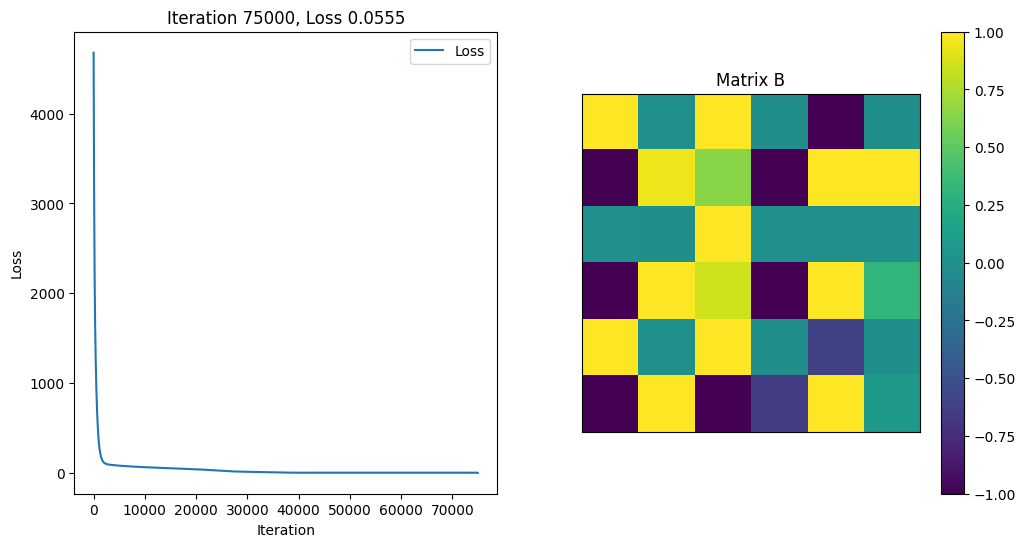

Current B at iteration 75000:
[[ 2.0741355e+00  4.9862312e-05  1.4229026e+00 -1.6254606e-04
  -2.3804431e+00 -8.0189295e-04]
 [-1.2997291e+00  9.4723767e-01  6.4141554e-01 -2.1740911e+00
   1.4915907e+00  1.2486954e+00]
 [ 1.8860766e-05 -4.9508410e-05  4.5415549e+00  6.0780003e-05
   9.1612572e-05  4.7772750e-04]
 [-3.9630494e+00  1.1139524e+00  8.5464436e-01 -1.5568167e+00
   3.8621621e+00  3.1927669e-01]
 [ 2.4389958e+00  1.5469785e-05  7.0042701e+00 -2.2095570e-04
  -6.0951817e-01 -8.4740436e-04]
 [-7.5230970e+00  1.3098122e+00 -1.0475085e+01 -6.5500450e-01
   1.8803432e+00  8.1230886e-02]]


In [ ]:
# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

# Use the grad function from jax
grad_loss = jit(grad(loss))

# Now optimize this with a gradient descent loop to find B

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 4e-4
iterations = 75_000
update_frequency = 5000

# Perform gradient descent with periodic updates
B = B_init
#B = jnp.arange(1, 37).reshape(6,6) + B_init
loss_values = []
for i in range(iterations):
    # Compute gradient
    gradient = grad_loss(B)

    # Update B
    B -= learning_rate * gradient

    # Compute and track loss
    current_loss = loss(B)
    loss_values.append(current_loss)

    # Update plot and show matrix B every 100 iterations
    if (i + 1) % update_frequency == 0 or i == 0:
        clear_output(wait=True)

        # Plotting the loss
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(loss_values, label='Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

        # Showing the matrix B
        plt.subplot(1, 2, 2)
        plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title('Matrix B')
        plt.xticks([])
        plt.yticks([])

        display(plt.gcf())
        plt.close()

        # Printing the current matrix B
        print(f'Current B at iteration {i+1}:\n{B}')

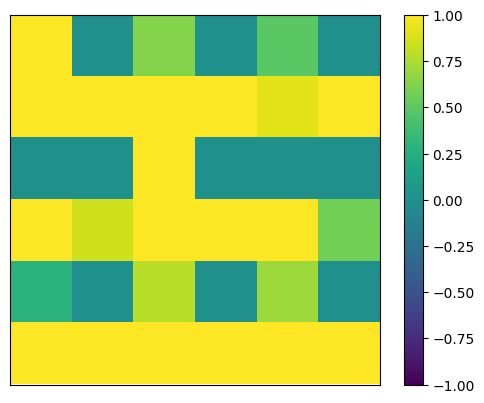

In [ ]:
# Number of sims
N = 10
B_list = np.zeros((N, 6, 6))

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 4e-4
iterations = 75_000
update_frequency = 5000

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

# Use the grad function from jax
grad_loss = jit(grad(loss))


for idx in range(N):
  # Use key to generate random values for initial guess
  key = random.key(idx)
  B_init = random.uniform(key, (6,6), minval=2, maxval=7, dtype=jnp.float32)
  B_init = 10*random.normal(key, (6,6))

  # Now optimize this with a gradient descent loop to find B
  # Perform gradient descent with periodic updates
  B = B_init
  loss_values = []

  for i in range(iterations):
      # Compute gradient
      gradient = grad_loss(B)

      # Update B
      B -= learning_rate * gradient

      # Compute and track loss
      current_loss = loss(B)
      loss_values.append(current_loss)

      # Update plot and show matrix B every 100 iterations
      if iterations - i == 1:
          clear_output(wait=True)

          # Plotting the loss
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(loss_values, label='Loss')
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

          # Showing the matrix B
          plt.subplot(1, 2, 2)
          plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
          plt.colorbar()
          plt.title('Matrix B')
          plt.xticks([])
          plt.yticks([])

          display(plt.gcf())
          plt.close()

          B_list[idx] = B


B_sum = jnp.sum(jnp.abs(B_list), axis=0) / N
print(B_sum)

clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# NOTE: It seems to matter if we leave out the reverse structure constants (i.e. c^n_ij where i>j being left out) or not.
# If we use random key 7, we get the diagonal solution when we leave out reverse structure constants, but other solution when we add them.

# Adam Optimizer Testing

[[ 9.9978364e-01 -8.9620209e+00  1.2813793e+00]
 [ 2.2369174e-04 -3.1127398e+00  1.3741388e+01]
 [-1.9363215e-05  8.9255518e-05 -3.1132200e+00]]


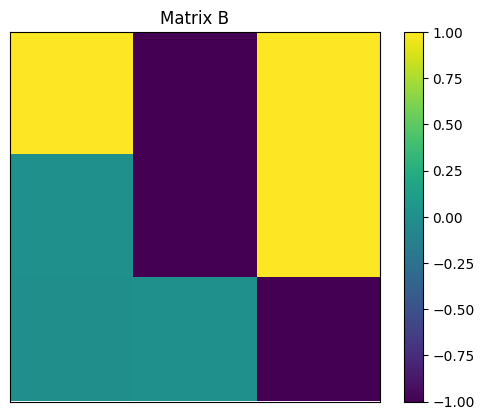

"\nloss_values = []\nfor i in range(iterations):\n    # Compute gradient\n    gradient = grad_loss(B) \n\n    # Update B\n    B -= learning_rate * gradient\n\n    # Compute and track loss\n    current_loss = loss(B)\n    if (i+1) % 100 or i == 0:\n      loss_values.append(current_loss)\n\n    # Update plot and show matrix B every 100 iterations\n    if (i + 1) % update_frequency == 0 or i == 0:\n        clear_output(wait=True)\n\n        # Plotting the loss\n        plt.figure(figsize=(12, 6))\n        plt.subplot(1, 2, 1)\n        plt.plot(loss_values, label='Loss')\n        plt.xlabel('Iteration')\n        plt.ylabel('Loss')\n        plt.legend()\n        plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')\n\n        # Showing the matrix B\n        plt.subplot(1, 2, 2)\n        plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)\n        plt.colorbar()\n        plt.title('Matrix B')\n        plt.xticks([])\n        plt.yticks([])\n\n        display(plt.gcf())\n        plt.close()\n\n  

In [ ]:
# Testing
# Use key to generate random values for initial guess
key = random.key(22)
B_init = 10*random.normal(key, (3,3), dtype=jnp.float32)

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c,B,B)
  rhs = jnp.einsum("jik,kn->nij",c,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-5)

# Use the grad function from jax
grad_loss = jit(grad(loss))

# Now optimize this with a gradient descent loop to find B
# Keep track of the loss

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 3e-3
iterations = 35_000
update_frequency = 5000

# Use ADAM Solver
solver = optax.adam(learning_rate)
params = B_init
opt_state = solver.init(params)

for _ in range(5_000):
  grad_adam = grad_loss(params)
  updates, opt_state = solver.update(grad_adam, opt_state, params)
  params = optax.apply_updates(params, updates)
  #print('Objective function: {:.2E}'.format(loss(params)))

print(params)

plt.imshow(params, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Matrix B')
plt.xticks([])
plt.yticks([])
plt.show()

# Perform gradient descent with periodic updates
B = B_init
#B = jnp.arange(1, 10).reshape(3,3) + B_init
"""
loss_values = []
for i in range(iterations):
    # Compute gradient
    gradient = grad_loss(B)

    # Update B
    B -= learning_rate * gradient

    # Compute and track loss
    current_loss = loss(B)
    if (i+1) % 100 or i == 0:
      loss_values.append(current_loss)

    # Update plot and show matrix B every 100 iterations
    if (i + 1) % update_frequency == 0 or i == 0:
        clear_output(wait=True)

        # Plotting the loss
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(loss_values, label='Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

        # Showing the matrix B
        plt.subplot(1, 2, 2)
        plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title('Matrix B')
        plt.xticks([])
        plt.yticks([])

        display(plt.gcf())
        plt.close()

        # Printing the current matrix B
        print(f'Current B at iteration {i+1}:\n{B}')
"""

In [ ]:
# Meeting Daniel

# Eerste Deel afschrijven voor 26 April
# Tot dan numerieke deel bijwerken
#



# TODO:
# Checken of helft structure constants ook werkt? En zoja is het dan sneller?
# Eerst Adjoint symmetries aftrekken?

# Finding B Matrix Burgers Eq

In [ ]:
# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((5,5,5))

# regular values
c_heat = c_heat.at[2,0,0].set(1)
c_heat = c_heat.at[4,0,3].set(2)
c_heat = c_heat.at[2,1,1].set(2)

c_heat = c_heat.at[3,1,0].set(2)
c_heat = c_heat.at[4,1,2].set(4)
c_heat = c_heat.at[3,2,3].set(1)
c_heat = c_heat.at[4,2,4].set(2)

# reverse values
c_heat = c_heat.at[0,2,0].set(-1)
c_heat = c_heat.at[0,4,3].set(-2)
c_heat = c_heat.at[1,2,1].set(-2)

c_heat = c_heat.at[1,3,0].set(-2)
c_heat = c_heat.at[1,4,2].set(-4)
c_heat = c_heat.at[2,3,3].set(-1)
c_heat = c_heat.at[2,4,4].set(-2)

print(c_heat)

[[[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [-1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0. -2.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0. -2.  0.  0.  0.]
  [-2.  0.  0.  0.  0.]
  [ 0.  0. -4.  0.  0.]]

 [[ 1.  0.  0.  0.  0.]
  [ 0.  2.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0. -1.  0.]
  [ 0.  0.  0.  0. -2.]]

 [[ 0.  0.  0.  0.  0.]
  [ 2.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  2.  0.]
  [ 0.  0.  4.  0.  0.]
  [ 0.  0.  0.  0.  2.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]]


## Finding Diagonal B Matrix

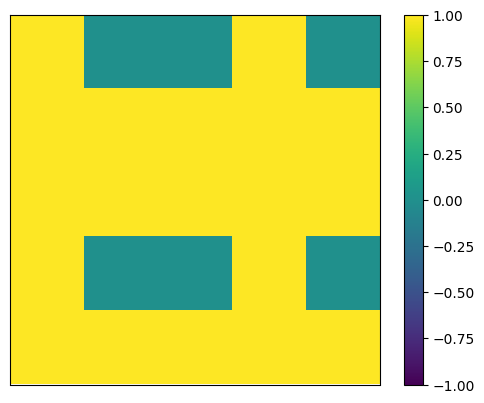

In [ ]:
# Number of sims
N = 10
B_list = np.zeros((N, 5, 5))

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 4e-4
iterations = 75_000
update_frequency = 5000

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

# Use the grad function from jax
grad_loss = jit(grad(loss))


for idx in range(N):
  # Use key to generate random values for initial guess
  key = random.key(idx)
  B_init = 10*random.normal(key, (5,5))

  # Now optimize this with a gradient descent loop to find B
  # Perform gradient descent with periodic updates
  B = B_init
  loss_values = []

  for i in range(iterations):
      # Compute gradient
      gradient = grad_loss(B)

      # Update B
      B -= learning_rate * gradient

      # Compute and track loss
      current_loss = loss(B)
      loss_values.append(current_loss)

      # Update plot and show matrix B every 100 iterations
      if iterations - i == 1:
          clear_output(wait=True)

          # Plotting the loss
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(loss_values, label='Loss')
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

          # Showing the matrix B
          plt.subplot(1, 2, 2)
          plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
          plt.colorbar()
          plt.title('Matrix B')
          plt.xticks([])
          plt.yticks([])

          display(plt.gcf())
          plt.close()

          B_list[idx] = B


B_sum = jnp.sum(jnp.abs(B_list), axis=0) / N
print(B_sum)

clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

Now redo the same procedure but with different information

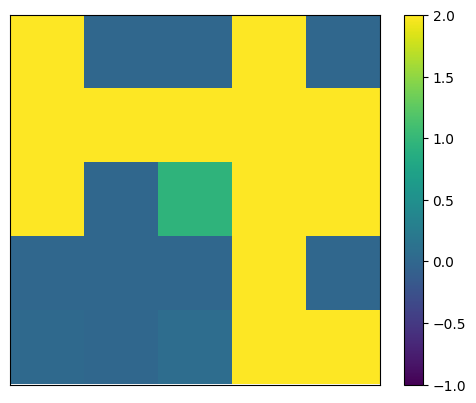

In [ ]:
# Number of sims
N = 5
B_list = np.zeros((N, 5, 5))

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 4e-4
iterations = 80_000
update_frequency = 5000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#             (3,2),
#             (4,2), (4,3), (4,5)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,3,3,3), (1,2,4,1,1,2,4))
y = np.zeros(7)

# Keep already known values of B constant
@jit
def keep_constant(B, indices):
  B = B.at[indices].set(y)
  return B

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

# Use the grad function from jax
grad_loss = jit(grad(loss))


for idx in range(N):
  # Use key to generate random values for initial guess
  key = random.key(idx)
  B_init = 10*random.normal(key, (5,5))

  # Now optimize this with a gradient descent loop to find B
  # Perform gradient descent with periodic updates
  B = B_init
  B = keep_constant(B, zero_list)
  print(B)

  loss_values = []

  for i in range(iterations):
      # Compute gradient
      gradient = grad_loss(B)

      # Update B
      B -= learning_rate * gradient
      B = keep_constant(B, zero_list)

      # Compute and track loss
      current_loss = loss(B)
      loss_values.append(current_loss)

      # Update plot and show matrix B every 100 iterations
      if iterations - i == 1:
          clear_output(wait=True)

          # Plotting the loss
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(loss_values, label='Loss')
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

          # Showing the matrix B
          plt.subplot(1, 2, 2)
          plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
          plt.colorbar()
          plt.title('Matrix B')
          plt.xticks([])
          plt.yticks([])

          display(plt.gcf())
          plt.close()

          B_list[idx] = B


B_sum = jnp.sum(jnp.abs(B_list), axis=0) / N
print(B_sum)

clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

Find new values again after new information

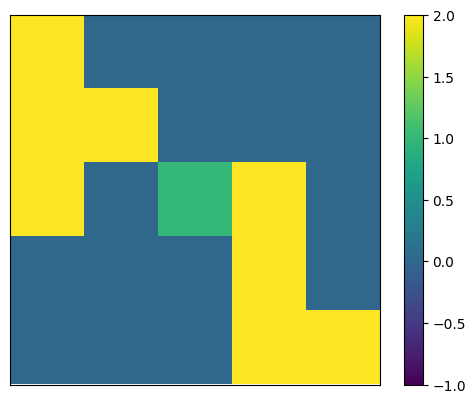

In [ ]:
# Number of sims
N = 8
B_list = np.zeros((N, 5, 5))
zero_determinant_counter = 0

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 4e-4
iterations = 60_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,3), (1,4), (1,5),
#             (3,2), (3,3)
#             (4,1), (4,2), (4,3), (4,5),
#             (5,1), (5,2), (5,3)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,2,2,3,3,3,3,4,4,4), (1,2,3,4,1,2,0,1,2,4,0,1,2))
y = np.array([0,0,0,0,0,1,0,0,0,0,0,0,0])

# Keep already known values of B constant
@jit
def keep_constant(B, indices):
  B = B.at[indices].set(y)
  return B

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

# Use the grad function from jax
grad_loss = jit(grad(loss))


for idx in range(N):
  # Use key to generate random values for initial guess
  key = random.key(idx)
  B_init = 10*random.normal(key, (5,5))

  # Now optimize this with a gradient descent loop to find B
  # Perform gradient descent with periodic updates
  B = B_init
  B = keep_constant(B, zero_list)
  print(B)

  loss_values = []

  for i in range(iterations):
      # Compute gradient
      gradient = grad_loss(B)

      # Update B
      B -= learning_rate * gradient
      B = keep_constant(B, zero_list)

      # Compute and track loss
      current_loss = loss(B)
      loss_values.append(current_loss)

      # Update plot and show matrix B every 100 iterations
      if iterations - i == 1:
          clear_output(wait=True)

          # Plotting the loss
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(loss_values, label='Loss')
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

          # Showing the matrix B
          plt.subplot(1, 2, 2)
          plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
          plt.colorbar()
          plt.title('Matrix B')
          plt.xticks([])
          plt.yticks([])

          display(plt.gcf())
          plt.close()

          if current_loss < 100:
            B_list[idx] = B
          else:
            zero_determinant_counter +=1


B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)
print(B_sum)

clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

Use the new information $b^4_5 = 0$, to see if the conditions lead to new information. NOTE: It seems that more and more runs end up going towards zero determinant as we restrict more and more values to be zero

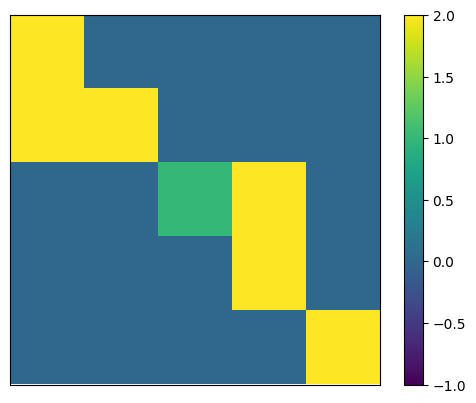

In [ ]:
# Number of sims
N = 8
B_list = np.zeros((N, 5, 5))
zero_determinant_counter = 0

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 4e-4
iterations = 60_000

# List of indices of which the value of B matrix is known to be zero ((3,3) is 1)
#zero_list = jnp.array([(1,2), (1,3), (1,4), (1,5),
#             (3,2), (3,3)
#             (4,1), (4,2), (4,3), (4,5),
#             (5,1), (5,2), (5,3), (5,4)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,2,2,3,3,3,3,4,4,4,4), (1,2,3,4,1,2,0,1,2,4,0,1,2,3))
y = np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0])

# Keep already known values of B constant
@jit
def keep_constant(B, indices):
  B = B.at[indices].set(y)
  return B

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

# Use the grad function from jax
grad_loss = jit(grad(loss))


for idx in range(N):
  # Use key to generate random values for initial guess
  key = random.key(idx)
  B_init = 10*random.normal(key, (5,5))

  # Now optimize this with a gradient descent loop to find B
  # Perform gradient descent with periodic updates
  B = B_init
  B = keep_constant(B, zero_list)
  print(B)

  loss_values = []

  for i in range(iterations):
      # Compute gradient
      gradient = grad_loss(B)

      # Update B
      B -= learning_rate * gradient
      B = keep_constant(B, zero_list)

      # Compute and track loss
      current_loss = loss(B)
      loss_values.append(current_loss)

      # Update plot and show matrix B every 100 iterations
      if iterations - i == 1:
          clear_output(wait=True)

          # Plotting the loss
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(loss_values, label='Loss')
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

          # Showing the matrix B
          plt.subplot(1, 2, 2)
          plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
          plt.colorbar()
          plt.title('Matrix B')
          plt.xticks([])
          plt.yticks([])

          display(plt.gcf())
          plt.close()

          if current_loss < 100:
            B_list[idx] = B
          else:
            zero_determinant_counter +=1


B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)


clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

Use the new information ($b^4_3=0$) to see if new conditions lead to new information

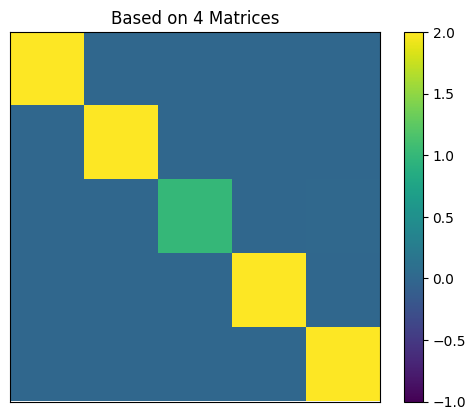

In [ ]:
# Number of sims
N = 8
B_list = np.zeros((N, 5, 5))
zero_determinant_counter = 0

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 4e-4
iterations = 60_000

# List of indices of which the value of B matrix is known to be zero ((3,3) is 1)
#zero_list = jnp.array([(1,2), (1,3), (1,4), (1,5),
#             (3,1), (3,2), (3,3), (3,4)
#             (4,1), (4,2), (4,3), (4,5),
#             (5,1), (5,2), (5,3), (5,4)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,2,2,2,2,3,3,3,3,4,4,4,4), (1,2,3,4,0,1,2,3,0,1,2,4,0,1,2,3))
y = np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0])

# Keep already known values of B constant
@jit
def keep_constant(B, indices):
  B = B.at[indices].set(y)
  return B

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

# Use the grad function from jax
grad_loss = jit(grad(loss))


for idx in range(N):
  # Use key to generate random values for initial guess
  key = random.key(idx)
  B_init = 10*random.normal(key, (5,5))

  # Now optimize this with a gradient descent loop to find B
  # Perform gradient descent with periodic updates
  B = B_init
  B = keep_constant(B, zero_list)
  print(B)

  loss_values = []

  for i in range(iterations):
      # Compute gradient
      gradient = grad_loss(B)

      # Update B
      B -= learning_rate * gradient
      B = keep_constant(B, zero_list)

      # Compute and track loss
      current_loss = loss(B)
      loss_values.append(current_loss)

      # Update plot and show matrix B every 100 iterations
      if iterations - i == 1:
          clear_output(wait=True)

          # Plotting the loss
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(loss_values, label='Loss')
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

          # Showing the matrix B
          plt.subplot(1, 2, 2)
          plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
          plt.colorbar()
          plt.title('Matrix B')
          plt.xticks([])
          plt.yticks([])

          display(plt.gcf())
          plt.close()

          if current_loss < 100:
            B_list[idx] = B
          else:
            zero_determinant_counter +=1


B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)


clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

## Finding Off-diagonal B Matrix

Start off with assumption $b^2_2=0$, use that to find new information

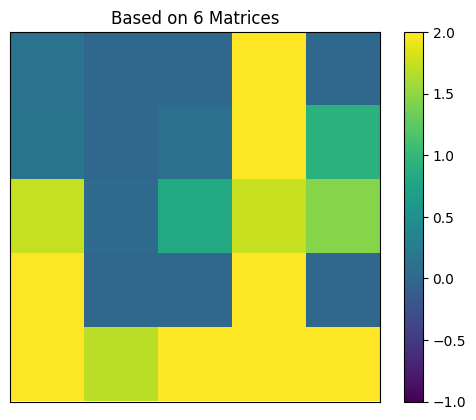

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (2,2)
#                       (4,2), (4,3), (4,5)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,1,3,3,3), (1,2,4,1,1,2,4))
y = np.array([0,0,0,0,0,0,0])

# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals):

  # Create list to store final B matrices in
  B_list = np.zeros((N, 5, 5))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_heat,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, tol):
    det = jnp.linalg.det(B)
    return jnp.isclose(det, 0, atol=tol)

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = 10*random.normal(key, (5,5))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    for i in range(iterations):
        # Compute gradient
        gradient = grad_loss(B)

        # Update B
        B -= learning_rate * gradient
        B = keep_constant(B, zero_list)

        # Compute and track loss
        current_loss = loss(B)
        loss_values.append(current_loss)

        # Update plot and show matrix B every 100 iterations
        if iterations - i == 1:
            clear_output(wait=True)

            # Plotting the loss
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

            # Showing the matrix B
            plt.subplot(1, 2, 2)
            plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Matrix B')
            plt.xticks([])
            plt.yticks([])

            display(plt.gcf())
            plt.close()

            if current_loss < 100:
              B_list[idx] = B
            else:
              zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter


# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

Using the previous found zeros with

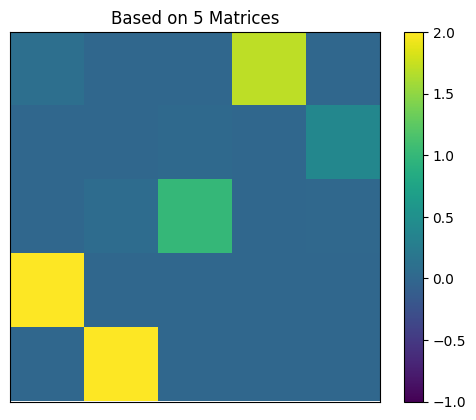

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (2,2), (2,4),
#                       (3,3), (3,4),
#                       (4,2), (4,3), (4,4), (4,5)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,1,1,2,2,3,3,3,3), (1,2,4,1,3,2,3,1,2,3,4))
y = np.array([0,0,0,0,0,-1,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

# Finding B Matrix Burger Eq with different assumption

In [ ]:
# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((5,5,5))

# regular values
c_heat = c_heat.at[2,0,0].set(1)
c_heat = c_heat.at[4,0,3].set(2)
c_heat = c_heat.at[2,1,1].set(2)

c_heat = c_heat.at[3,1,0].set(2)
c_heat = c_heat.at[4,1,2].set(4)
c_heat = c_heat.at[3,2,3].set(1)
c_heat = c_heat.at[4,2,4].set(2)

# reverse values
c_heat = c_heat.at[0,2,0].set(-1)
c_heat = c_heat.at[0,4,3].set(-2)
c_heat = c_heat.at[1,2,1].set(-2)

c_heat = c_heat.at[1,3,0].set(-2)
c_heat = c_heat.at[1,4,2].set(-4)
c_heat = c_heat.at[2,3,3].set(-1)
c_heat = c_heat.at[2,4,4].set(-2)

print(c_heat)

[[[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [-1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0. -2.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0. -2.  0.  0.  0.]
  [-2.  0.  0.  0.  0.]
  [ 0.  0. -4.  0.  0.]]

 [[ 1.  0.  0.  0.  0.]
  [ 0.  2.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0. -1.  0.]
  [ 0.  0.  0.  0. -2.]]

 [[ 0.  0.  0.  0.  0.]
  [ 2.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  2.  0.]
  [ 0.  0.  4.  0.  0.]
  [ 0.  0.  0.  0.  2.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]]


In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals):

  # Create list to store final B matrices in
  B_list = np.zeros((N, 5, 5))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_heat,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, tol):
    det = jnp.linalg.det(B)
    return jnp.isclose(det, 0, atol=tol)

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = 10*random.normal(key, (5,5))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    for i in range(iterations):
        # Compute gradient
        gradient = grad_loss(B)

        # Update B
        B -= learning_rate * gradient
        B = keep_constant(B, zero_list)

        # Compute and track loss
        current_loss = loss(B)
        loss_values.append(current_loss)

        # Update plot and show matrix B every 100 iterations
        if iterations - i == 1:
            clear_output(wait=True)

            # Plotting the loss
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

            # Showing the matrix B
            plt.subplot(1, 2, 2)
            plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Matrix B')
            plt.xticks([])
            plt.yticks([])

            display(plt.gcf())
            plt.close()

            if current_loss < 100:
              B_list[idx] = B
            else:
              zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

## Assumption b[2,1]!=0, sets b[3,1]=0

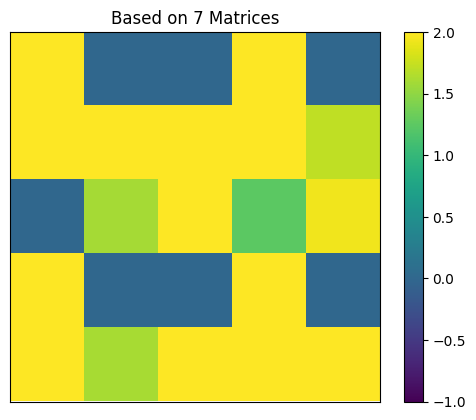

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (3,1),
#                       (4,2), (4,3), (4,5)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,3,3,3), (1,2,4,0,1,2,4))
y = np.array([0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

### Assumption b[4,1] != 0, sets b[1,1]=0

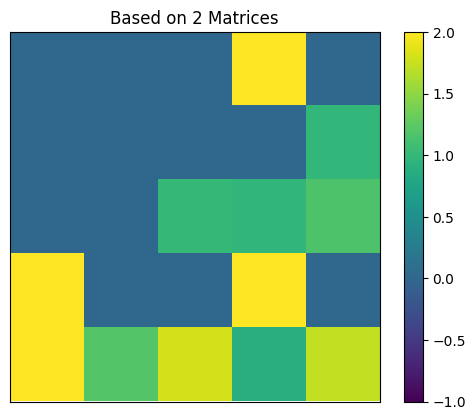

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,1), (1,2), (1,3), (1,5),
#                       (3,1),
#                       (4,2), (4,3), (4,5)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,2,3,3,3), (0,1,2,4,0,1,2,4))
y = np.array([0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

Sets b[2,1] to zero which does not hold with our assumption

### Assumption b[4,1]=0, sets b[4,1] to zero

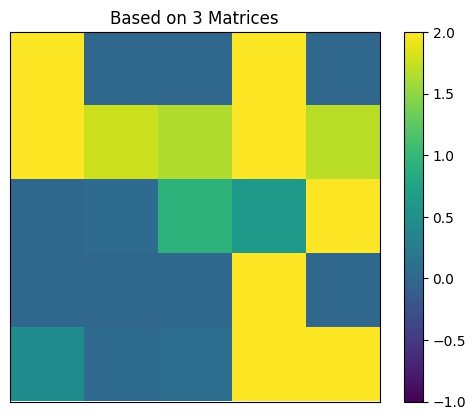

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (3,1),
#                       (4,1), (4,2), (4,3), (4,5)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,3,3,3,3), (1,2,4,0,0,1,2,4))
y = np.array([0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

set b[5,4] = 0

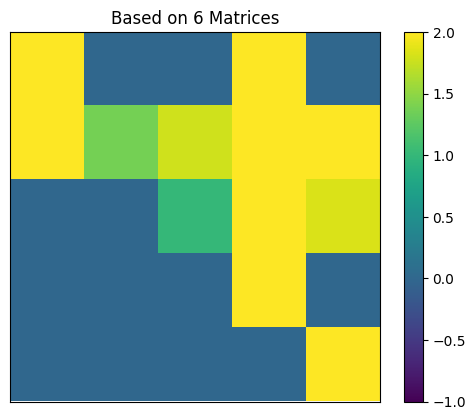

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero,
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (3,1), (3,2)
#                       (4,1), (4,2), (4,3), (4,5),
#                       (5,2), (5,3), (5,4)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,3,3,3,3,4,4,4), (1,2,4,0,1,0,1,2,4,1,2,3))
y = np.array([0,0,0,0,0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

Set b[3,4] = 0

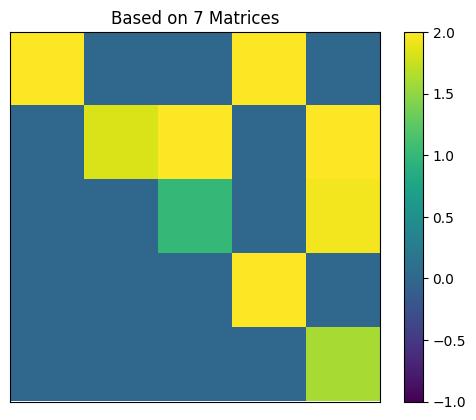

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero,
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (3,1), (3,2), (3,4),
#                       (4,1), (4,2), (4,3), (4,5),
#                       (5,2), (5,3), (5,4)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,3,3,3,3,4,4,4), (1,2,4,0,1,3,0,1,2,4,1,2,3))
y = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

## Assumption b[2,1]=0

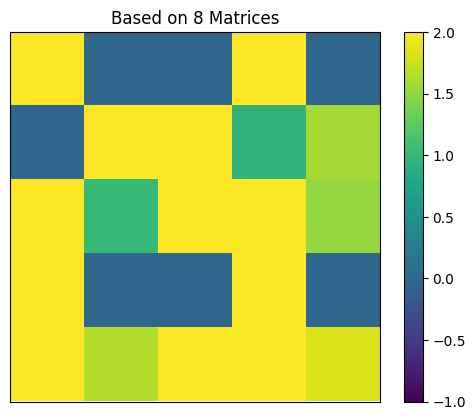

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (2,1),
#                       (4,2), (4,3), (4,5)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,1,3,3,3), (1,2,4,0,1,2,4))
y = np.array([0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

### Assumption b[1,1] != 0

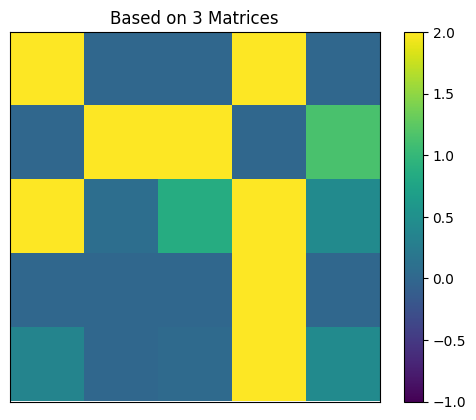

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (2,1),
#                       (4,1), (4,2), (4,3), (4,5)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,1,3,3,3,3), (1,2,4,0,0,1,2,4))
y = np.array([0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

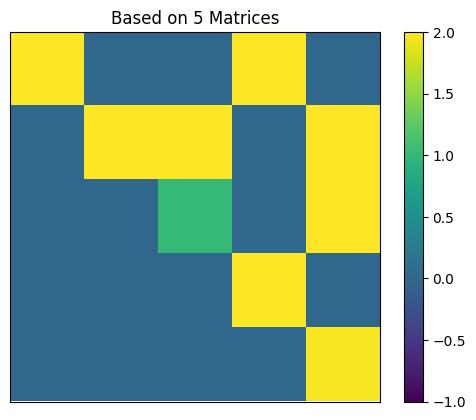

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,3), (1,5),
#                       (2,1), (2,4),
#                       (3,2),
#                       (4,1), (4,2), (4,3), (4,5),
#                       (5,2), (5,3), (5,4)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,1,1,2,3,3,3,3,4,4,4), (1,2,4,0,3,1,0,1,2,4,1,2,3))
y = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

Set b[1,4] = 0

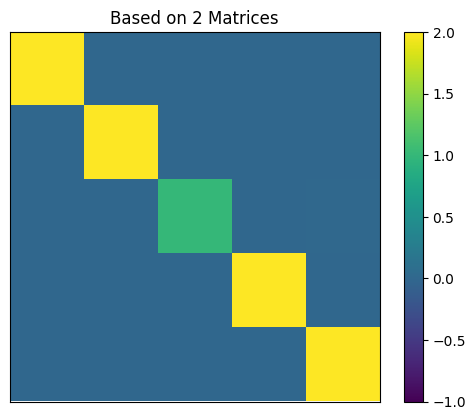

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero,
#zero_list = jnp.array([(1,2), (1,3), (1,4), (1,5),
#                       (2,1), (2,4),
#                       (3,1), (3,2), (3,4),
#                       (4,1), (4,2), (4,3), (4,5),
#                       (5,1), (5,2), (5,3), (5,4)])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,0,1,1,2,2,2,3,3,3,3,4,4,4,4), (1,2,3,4,0,3,0,1,3,0,1,2,4,0,1,2,3))
y = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
clear_output(wait=True)
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
plt.show()

# Finding B Matrix Heat Equation Blind

In [ ]:
N_gen = 6

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((N_gen,N_gen,N_gen))

# regular values   (same generator order as in R. J. Gray)
c_heat = c_heat.at[3,0,0].set(1)
c_heat = c_heat.at[4,3,4].set(1)
c_heat = c_heat.at[4,0,2].set(-1)

c_heat = c_heat.at[5,0,4].set(2)
c_heat = c_heat.at[3,1,1].set(2)
c_heat = c_heat.at[4,1,0].set(2)
c_heat = c_heat.at[5,3,5].set(2)

c_heat = c_heat.at[5,1,2].set(-2)
c_heat = c_heat.at[5,1,3].set(4)

# reverse values
c_heat = c_heat.at[0,3,0].set(-1)
c_heat = c_heat.at[3,4,4].set(-1)
c_heat = c_heat.at[0,4,2].set(1)

c_heat = c_heat.at[0,5,4].set(-2)
c_heat = c_heat.at[1,3,1].set(-2)
c_heat = c_heat.at[1,4,0].set(-2)
c_heat = c_heat.at[3,5,5].set(-2)

c_heat = c_heat.at[1,5,2].set(2)
c_heat = c_heat.at[1,5,3].set(-4)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_heat,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, tol):
    det = jnp.linalg.det(B)
    return jnp.isclose(det, 0, atol=tol)

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = 10*random.normal(key, (N_gen,N_gen))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    for i in range(iterations):
        # Compute gradient
        gradient = grad_loss(B)

        # Update B
        B -= learning_rate * gradient
        B = keep_constant(B, zero_list)

        # Compute and track loss
        current_loss = loss(B)
        loss_values.append(current_loss)

        # Update plot and show matrix B every 100 iterations
        if iterations - i == 1:
            clear_output(wait=True)

            # Plotting the loss
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

            # Showing the matrix B
            plt.subplot(1, 2, 2)
            plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Matrix B')
            plt.xticks([])
            plt.yticks([])

            display(plt.gcf())
            plt.close()

            if current_loss < 100:
              B_list[idx] = B
            else:
              zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

In [ ]:
# Function that plots averaged B matrix, returns nothing
def matrix_plotter(B_sum, zero_determinant_counter):
  plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])
  plt.show()

Find first zeroes without using any Adjoint matrices

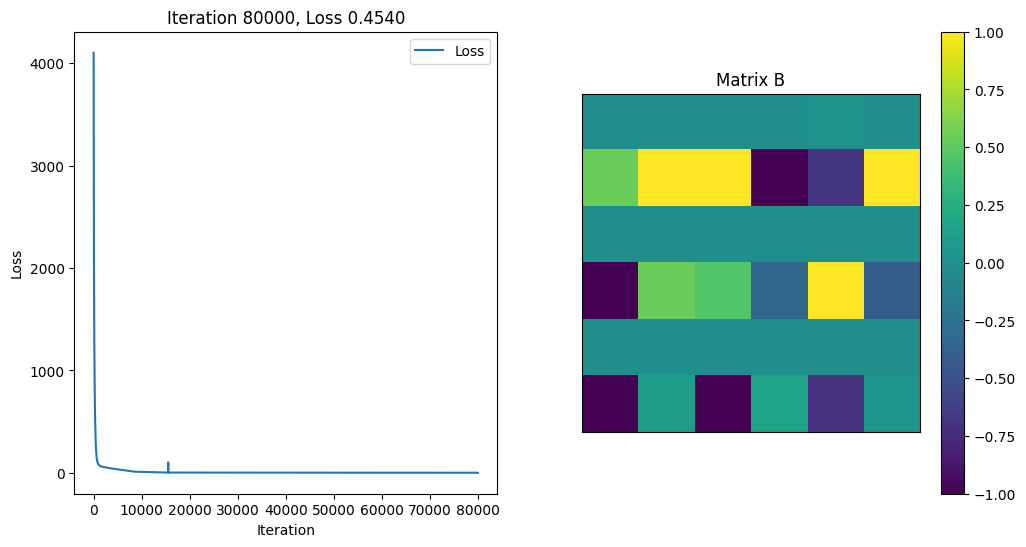

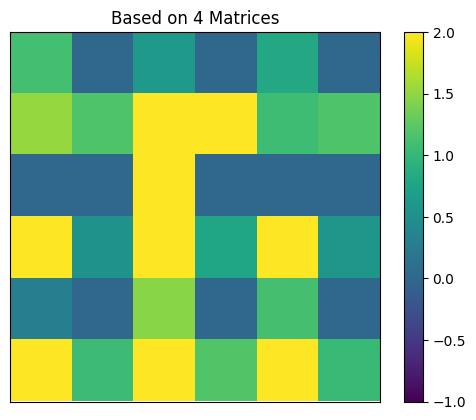

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 80_000

# NORMALLY functions, does not work yet when none of the values are known to be zero
# Create list to store final B matrices in
B_list = np.zeros((N, N_gen, N_gen))
zero_determinant_counter = 0

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, tol):
  det = jnp.linalg.det(B)
  return jnp.isclose(det, 0, atol=tol)

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 100*zero_determinant(B, 1e-6)

# Use the grad function from jax
grad_loss = jit(grad(loss))

for idx in range(N):
  # Use key to generate random values for initial guess
  key = random.key(idx)
  B_init = 10*random.normal(key, (N_gen,N_gen))

  # Set starting B matrix
  B = B_init
  print(B)

  loss_values = []

  for i in range(iterations):
      # Compute gradient
      gradient = grad_loss(B)

      # Update B
      B -= learning_rate * gradient

      # Compute and track loss
      current_loss = loss(B)
      loss_values.append(current_loss)

      # Update plot and show matrix B every 100 iterations
      if iterations - i == 1:
          clear_output(wait=True)

          # Plotting the loss
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(loss_values, label='Loss')
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

          # Showing the matrix B
          plt.subplot(1, 2, 2)
          plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
          plt.colorbar()
          plt.title('Matrix B')
          plt.xticks([])
          plt.yticks([])

          display(plt.gcf())
          plt.close()

          if current_loss < 100:
            B_list[idx] = B
          else:
            zero_determinant_counter +=1


B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

## Assumption b[1,5] != 0

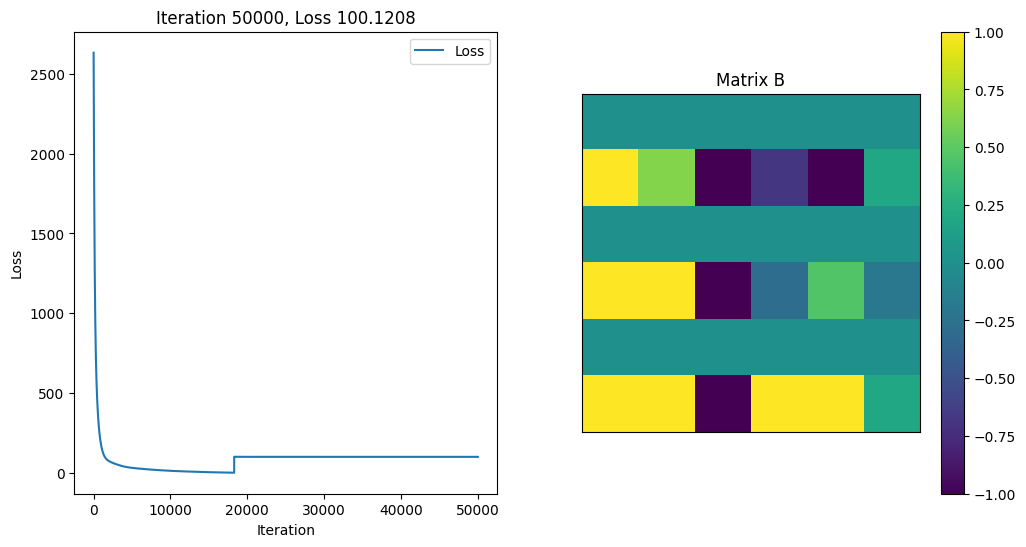

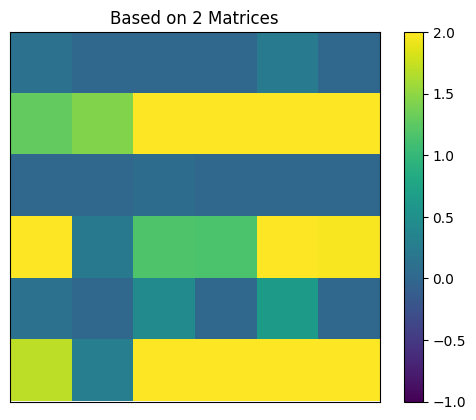

In [ ]:
# Number of sims
N = 12
learning_rate = 5e-4
iterations = 50_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0), (1,3,5,0,1,3,4,5,1,3,5,2))
y = np.array([0,0,0,0,0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

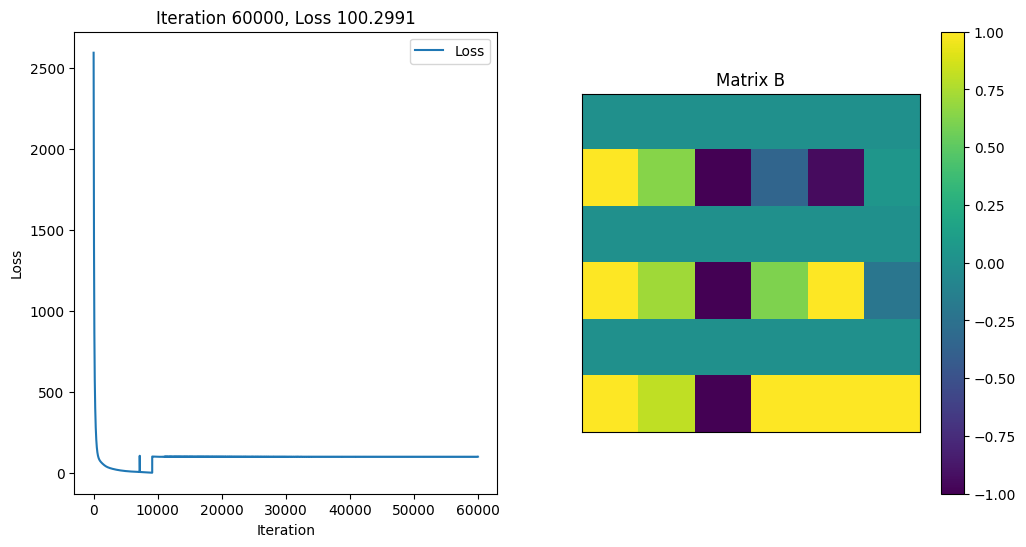

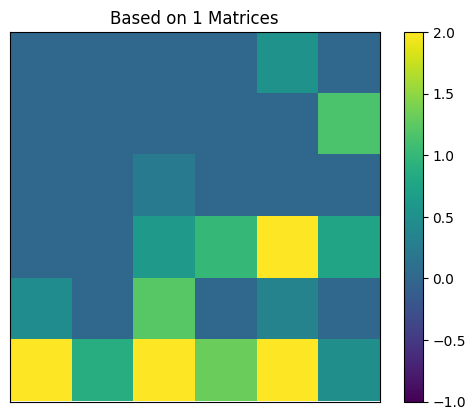

In [ ]:
# Number of sims
N = 12
learning_rate = 1e-3
iterations = 60_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0), (1,3,5,0,1,3,4,5,1,3,5,2,0))
y = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

set b[6,1]=0

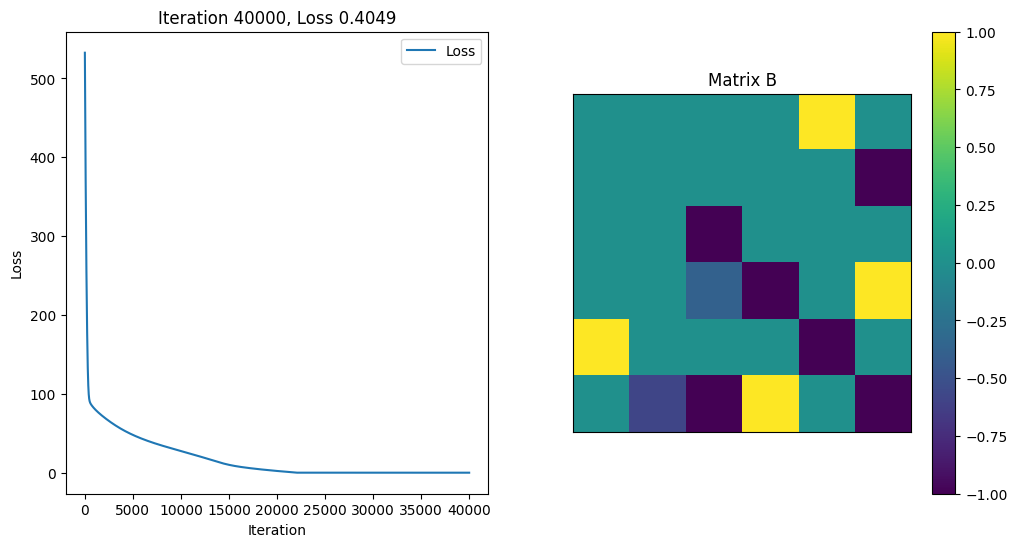

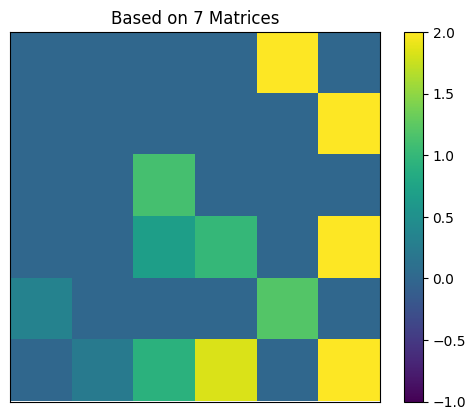

In [ ]:
# Number of sims
N = 12
learning_rate = 4e-4
iterations = 40_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1), (6,1), (2,1), (2,2), (2,3), (2,4), (2,5), (4,1), (4,2)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0,5,1,1,1,1,1,3,3), (1,3,5,0,1,3,4,5,1,3,5,2,0,0,0,1,2,3,4,0,1))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

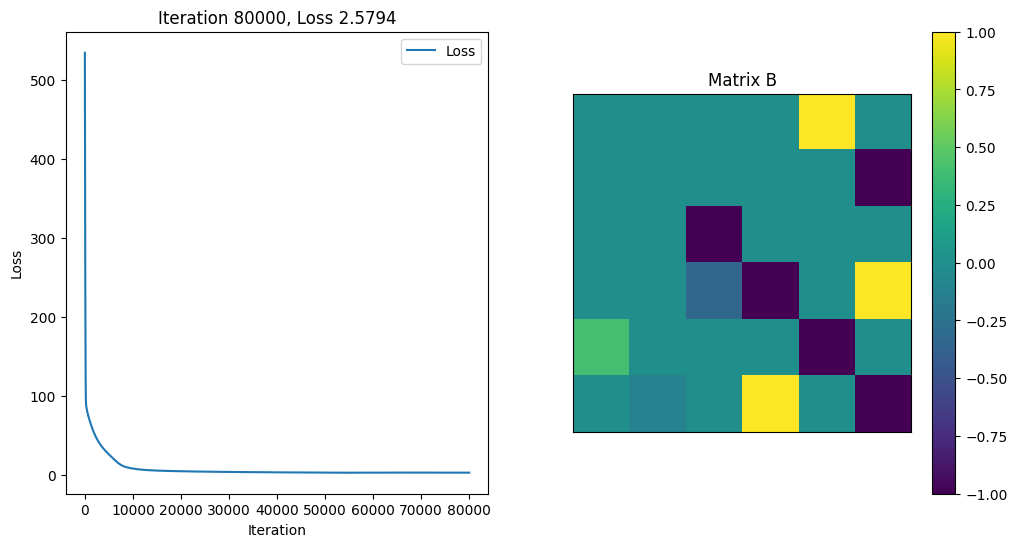

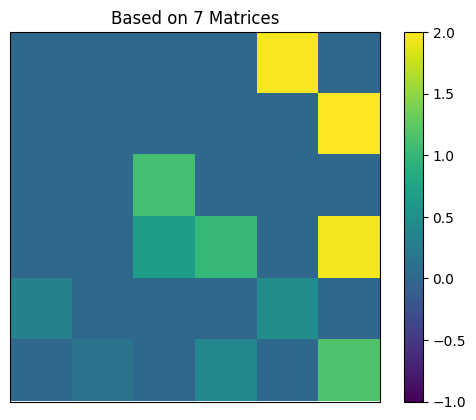

In [ ]:
# Number of sims
N = 12
learning_rate = 8e-4
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1), (6,1), (2,1), (2,2), (2,3), (2,4), (2,5), (4,1), (4,2), (6,3)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0,5,1,1,1,1,1,3,3,5), (1,3,5,0,1,3,4,5,1,3,5,2,0,0,0,1,2,3,4,0,1,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

## Assumption b[1,5] = 0

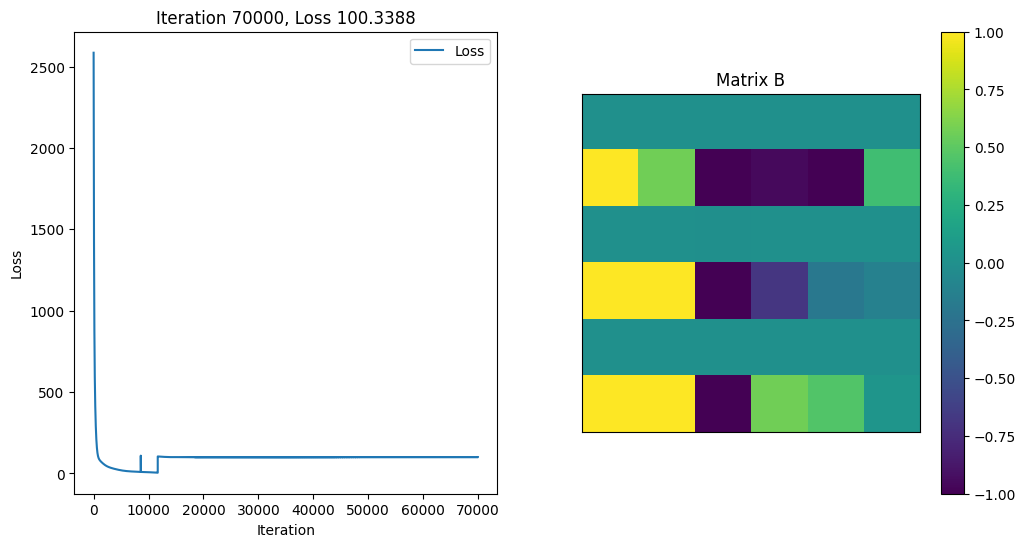

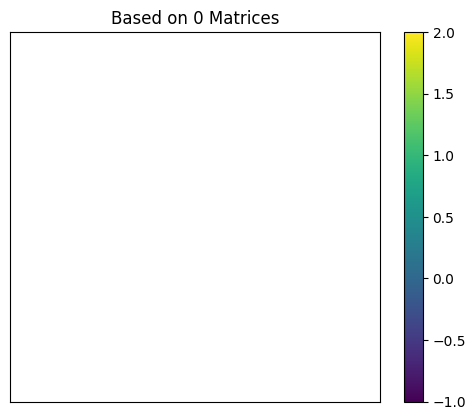

In [ ]:
# Add b[1,5] to zero list
# Number of sims
N = 12
learning_rate = 8e-4
iterations = 70_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,5)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0), (1,3,5,0,1,3,4,5,1,3,5,4))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Finding B matrix of Heat equation using normal dist for nonzero determinant

In [ ]:
N_gen = 6

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((N_gen,N_gen,N_gen))

# regular values   (same generator order as in R. J. Gray)
c_heat = c_heat.at[3,0,0].set(1)
c_heat = c_heat.at[4,3,4].set(1)
c_heat = c_heat.at[4,0,2].set(-1)

c_heat = c_heat.at[5,0,4].set(2)
c_heat = c_heat.at[3,1,1].set(2)
c_heat = c_heat.at[4,1,0].set(2)
c_heat = c_heat.at[5,3,5].set(2)

c_heat = c_heat.at[5,1,2].set(-2)
c_heat = c_heat.at[5,1,3].set(4)

# reverse values
c_heat = c_heat.at[0,3,0].set(-1)
c_heat = c_heat.at[3,4,4].set(-1)
c_heat = c_heat.at[0,4,2].set(1)

c_heat = c_heat.at[0,5,4].set(-2)
c_heat = c_heat.at[1,3,1].set(-2)
c_heat = c_heat.at[1,4,0].set(-2)
c_heat = c_heat.at[3,5,5].set(-2)

c_heat = c_heat.at[1,5,2].set(2)
c_heat = c_heat.at[1,5,3].set(-4)

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_heat,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = 10*random.normal(key, (N_gen,N_gen))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    for i in range(iterations):
        # Compute gradient
        gradient = grad_loss(B)

        # Update B
        B -= learning_rate * gradient
        B = keep_constant(B, zero_list)

        # Compute and track loss
        current_loss = loss(B)
        loss_values.append(current_loss)

        # Update plot and show matrix B every 100 iterations
        if iterations - i == 1:
            clear_output(wait=True)

            # Plotting the loss
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.legend()
            plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

            # Showing the matrix B
            plt.subplot(1, 2, 2)
            plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
            plt.colorbar()
            plt.title('Matrix B')
            plt.xticks([])
            plt.yticks([])

            display(plt.gcf())
            plt.close()

            if current_loss < 100:
              B_list[idx] = B
            else:
              zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

In [ ]:
# Function that plots averaged B matrix, returns nothing
def matrix_plotter(B_sum, zero_determinant_counter):
  plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])
  plt.show()

Finding first zeroes

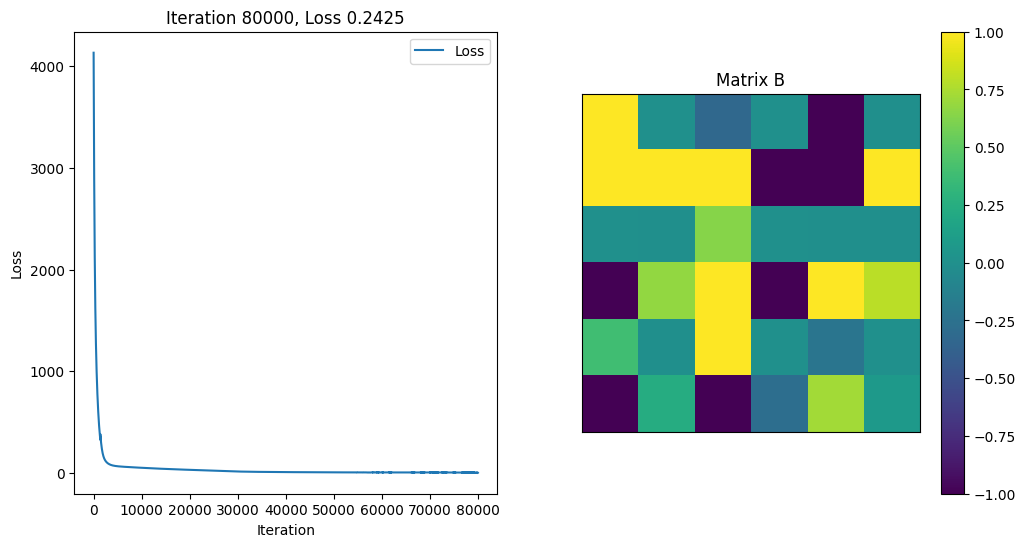

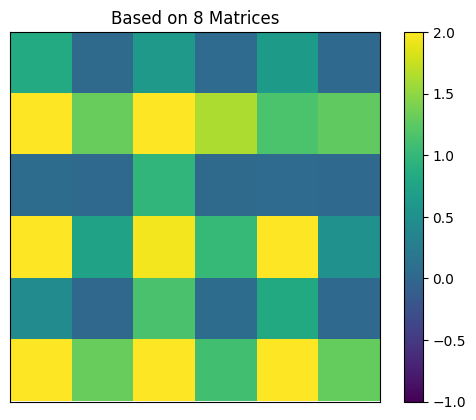

In [ ]:
# Number of sims
N = 8
learning_rate = 3e-4
iterations = 80_000

# NORMALLY functions, does not work yet when none of the values are known to be zero
# Create list to store final B matrices in
B_list = np.zeros((N, N_gen, N_gen))
zero_determinant_counter = 0

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, sig):
  det = jnp.linalg.det(B)
  res = jnp.exp(-0.5*((det/sig)**2)) / sig
  return res

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

# Use the grad function from jax
grad_loss = jit(grad(loss))

for idx in range(N):
  # Use key to generate random values for initial guess
  key = random.key(idx)
  B_init = 10*random.normal(key, (N_gen,N_gen))

  # Set starting B matrix
  B = B_init
  print(B)
  print(jnp.sqrt(jnp.sum(condition_on_B(B)**2)))
  print(zero_determinant(B, 1e-6))

  loss_values = []

  for i in range(iterations):
      # Compute gradient
      gradient = grad_loss(B)

      # Update B
      B -= learning_rate * gradient

      # Compute and track loss
      current_loss = loss(B)
      loss_values.append(current_loss)

      # Update plot and show matrix B every 100 iterations
      if iterations - i == 1:
          clear_output(wait=True)

          # Plotting the loss
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(loss_values, label='Loss')
          plt.xlabel('Iteration')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'Iteration {i+1}, Loss {current_loss:.4f}')

          # Showing the matrix B
          plt.subplot(1, 2, 2)
          plt.imshow(B, cmap='viridis', vmin=-1, vmax=1)
          plt.colorbar()
          plt.title('Matrix B')
          plt.xticks([])
          plt.yticks([])

          display(plt.gcf())
          plt.close()

          if current_loss < 100:
            B_list[idx] = B
          else:
            zero_determinant_counter +=1


B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

## Assumption b[1,5] != 0

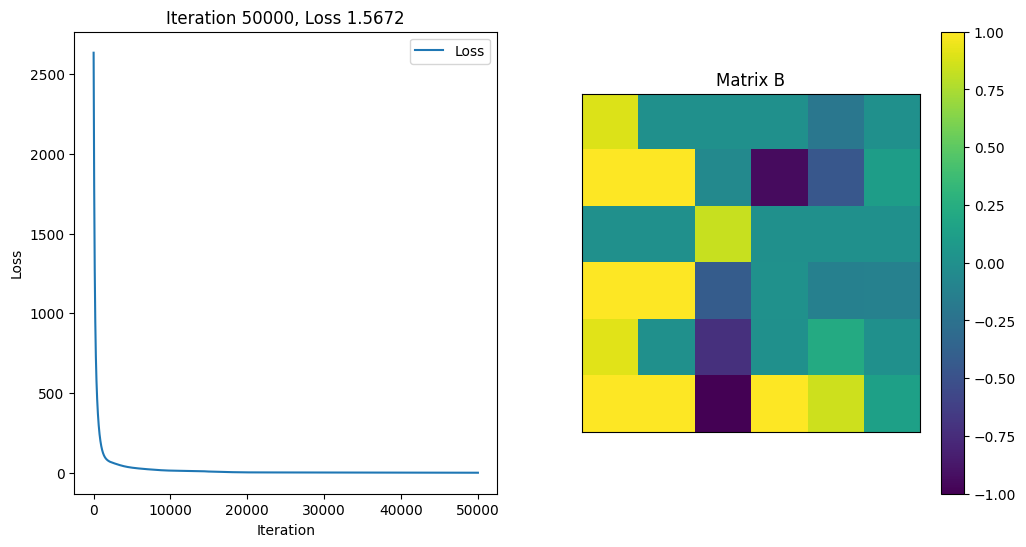

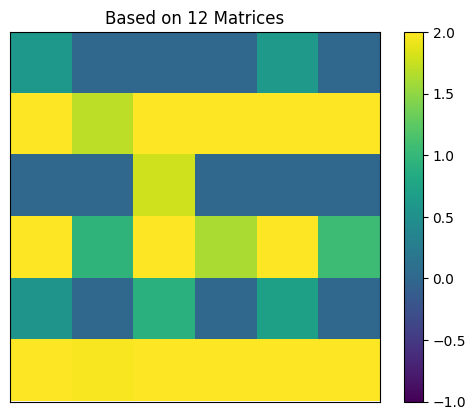

In [ ]:
# Number of sims
N = 10
learning_rate = 5e-4
iterations = 70_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0), (1,3,5,0,1,3,4,5,1,3,5,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Also set b[1,1] = 0 using b[1,5]!=0

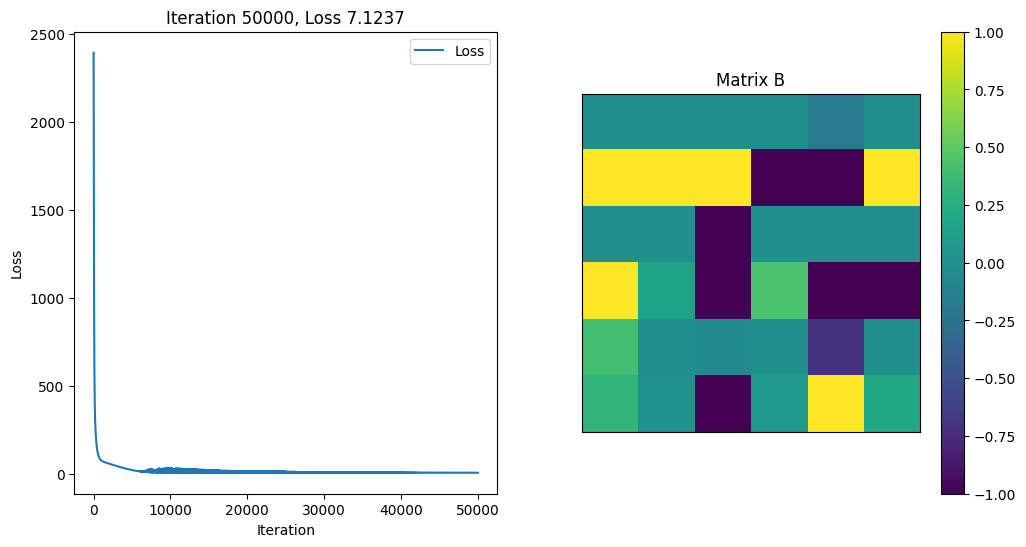

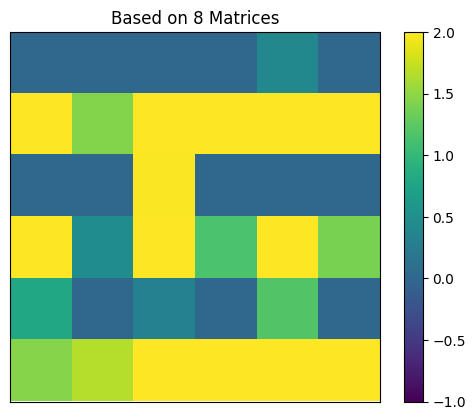

In [ ]:
# Number of sims
N = 8
learning_rate = 1e-3
iterations = 50_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0), (1,3,5,0,1,3,4,5,1,3,5,2,0))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

### Assumption b[2,2]!=0

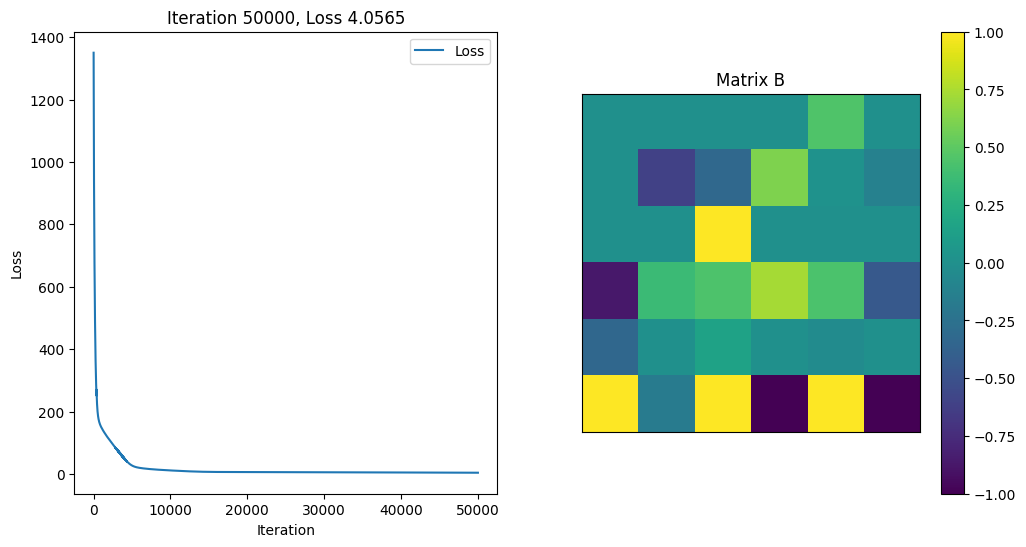

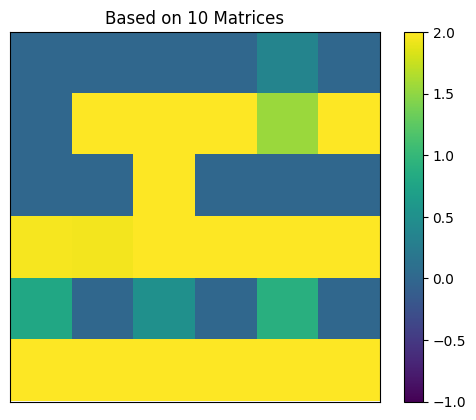

In [ ]:
# Add b[2,1] to zero list
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 50_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1), (2,1)            ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0,1), (1,3,5,0,1,3,4,5,1,3,5,2,0,0))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

set b[2,3]=0

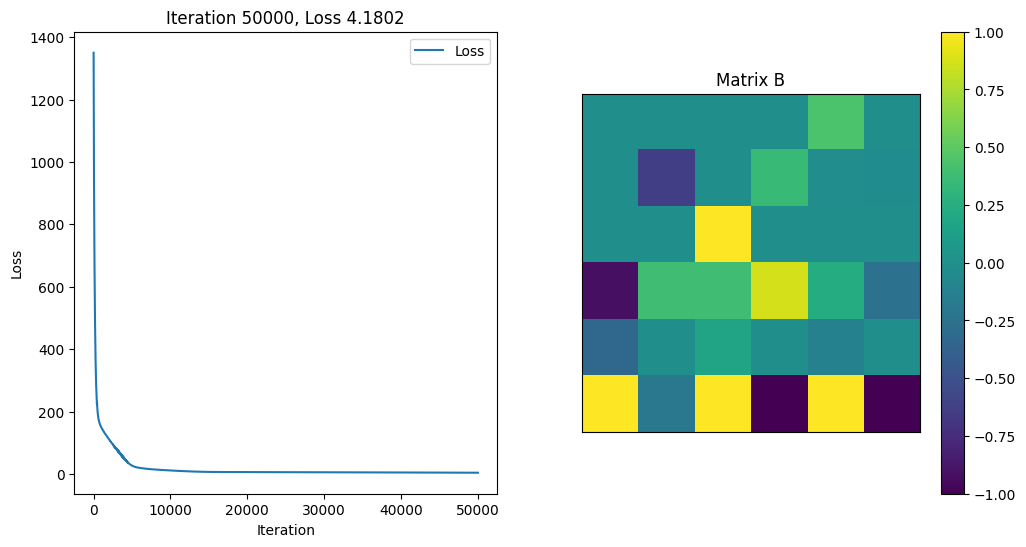

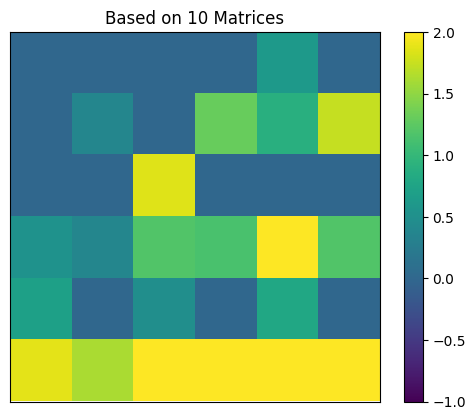

In [ ]:
# Add b[2,3] to zero list
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 50_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1), (2,1), (2,3)        ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0,1,1), (1,3,5,0,1,3,4,5,1,3,5,2,0,0,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

## Assumption b[1,5]=0

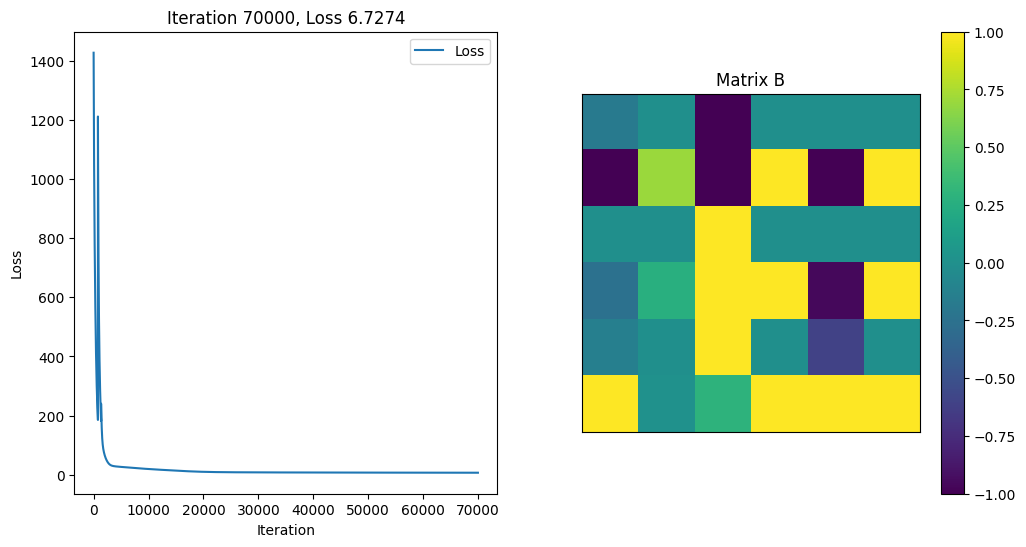

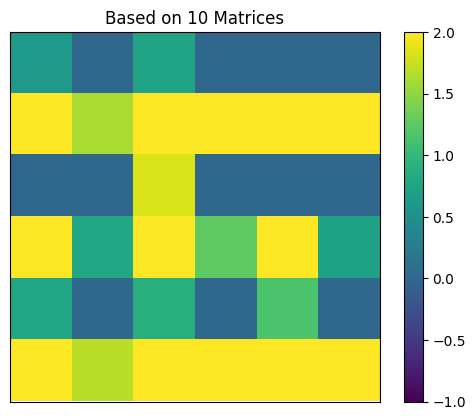

In [ ]:
# Number of sims
N = 10
learning_rate = 5e-4
iterations = 70_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,5)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0), (1,3,5,0,1,3,4,5,1,3,5,4))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

### Assumption b[1,1] != 0
Set b[1,3] = 0

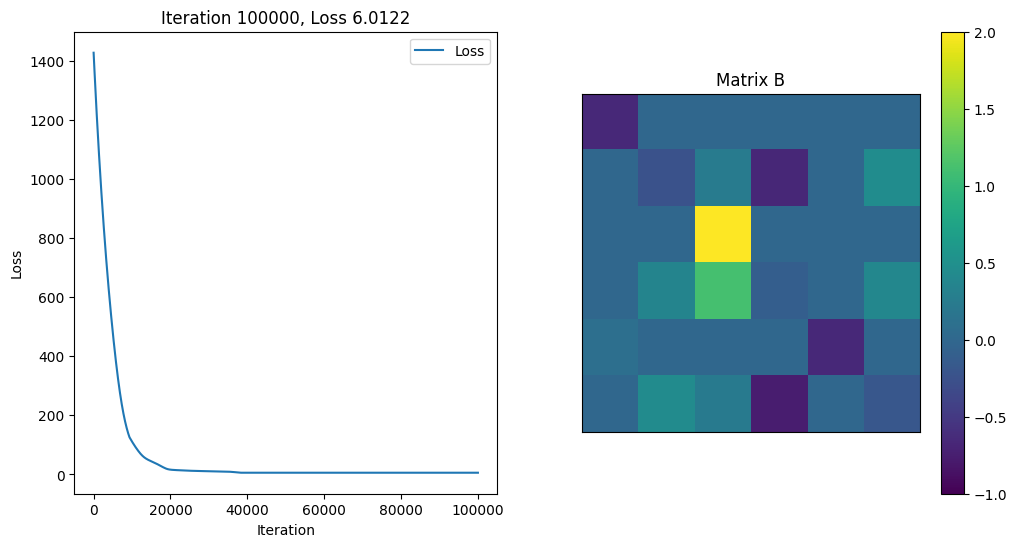

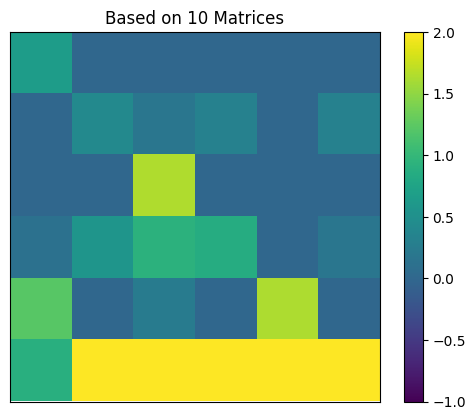

In [ ]:
# Number of sims
N = 10
learning_rate = 8e-4
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero, (3,3) is -1 (hoe te weten of +1 of -1 is?)
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,5), (1,3),             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0), (1,3,5,0,1,3,4,5,1,3,5,4,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Finding B matrix Heat eq using Norm dist and ADAM

In [ ]:
N_gen = 6

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((N_gen,N_gen,N_gen))

# regular values   (same generator order as in R. J. Gray)
c_heat = c_heat.at[3,0,0].set(1)
c_heat = c_heat.at[4,3,4].set(1)
c_heat = c_heat.at[4,0,2].set(-1)

c_heat = c_heat.at[5,0,4].set(2)
c_heat = c_heat.at[3,1,1].set(2)
c_heat = c_heat.at[4,1,0].set(2)
c_heat = c_heat.at[5,3,5].set(2)

c_heat = c_heat.at[5,1,2].set(-2)
c_heat = c_heat.at[5,1,3].set(4)

# reverse values
c_heat = c_heat.at[0,3,0].set(-1)
c_heat = c_heat.at[3,4,4].set(-1)
c_heat = c_heat.at[0,4,2].set(1)

c_heat = c_heat.at[0,5,4].set(-2)
c_heat = c_heat.at[1,3,1].set(-2)
c_heat = c_heat.at[1,4,0].set(-2)
c_heat = c_heat.at[3,5,5].set(-2)

c_heat = c_heat.at[1,5,2].set(2)
c_heat = c_heat.at[1,5,3].set(-4)

In [ ]:
# Function that plots averaged B matrix, returns nothing
def matrix_plotter(B_sum, zero_determinant_counter):
  plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])
  plt.show()

Objective function: 5.07E+03
Objective function: 1.38E+03
Objective function: 1.70E+02
Objective function: 1.26E+02
Objective function: 6.29E+01
Objective function: 2.83E+01
Objective function: 1.68E+00
Objective function: 6.39E-01
Objective function: 4.88E-01
Objective function: 4.12E-01
Objective function: 3.66E-01
Objective function: 3.38E-01
Objective function: 3.17E-01
Objective function: 3.02E-01
Objective function: 2.91E-01
Objective function: 2.81E-01
[[ 8.9659864e-01 -1.3203039e-04  7.7030158e-01 -7.6044147e-05
  -2.0073841e+00  2.9969435e-05]
 [ 2.2005265e+00 -1.2864027e+00 -1.9447341e+00  5.7612109e+00
  -4.9289088e+00 -6.4500985e+00]
 [ 1.7316610e-03 -2.8379136e-03 -5.9901750e-01 -3.7880442e-03
  -2.4476316e-04 -1.1742313e-03]
 [ 6.1581879e+00  5.1838624e-01  6.0090418e+00 -1.3218721e+00
  -1.4644460e+01  3.6013436e-01]
 [-3.6078614e-01 -7.2999852e-04  4.6014090e+00 -8.6706434e-04
   1.1197971e-01 -3.3776122e-04]
 [-5.3203979e+00 -2.0880485e-01  3.3810661e+01  1.2962113e-01

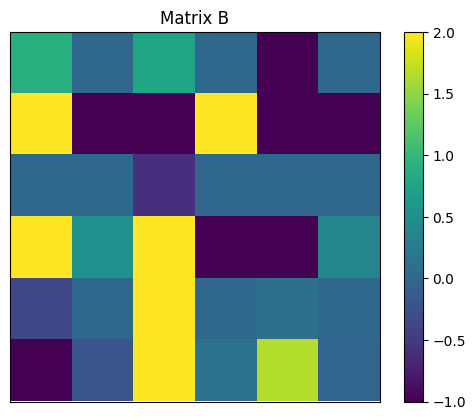

In [ ]:
# Testing
# Use key to generate random values for initial guess
key = random.key(2)
B_init = 10*random.normal(key, (N_gen,N_gen), dtype=jnp.float32)

# condition on B
def condition_on_B(B):
  lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
  rhs = jnp.einsum("jik,kn->nij",c_heat,B)
  return lhs - rhs

# zero determinant condition
def zero_determinant(B, sig):
  det = jnp.linalg.det(B)
  res = jnp.exp(-0.5*((det/sig)**2)) / sig
  return res

# loss function to be optimized, using frobenius norm
@jit
def loss(B):
  return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

# Use the grad function from jax
grad_loss = jit(grad(loss))

# Now optimize this with a gradient descent loop to find B
# Keep track of the loss

# Adjusted gradient descent parameters for updates every 100 iterations
learning_rate = 1e-3
iterations = 80_000
update_frequency = 5000

# Use ADAM Solver
solver = optax.adam(learning_rate)
params = B_init
opt_state = solver.init(params)

for iter in range(iterations):
  grad_adam = grad_loss(params)
  updates, opt_state = solver.update(grad_adam, opt_state, params)
  params = optax.apply_updates(params, updates)
  if iter % update_frequency == 0:
    print('Objective function: {:.2E}'.format(loss(params)))

print(params)

plt.imshow(params, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title('Matrix B')
plt.xticks([])
plt.yticks([])
plt.show()

Now do multiple runs with adam and take average B for better result?

In [ ]:
# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_heat,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = 10*random.normal(key, (N_gen,N_gen))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)
      updates, opt_state = solver.update(grad_adam, opt_state, params)

      params = optax.apply_updates(params, updates)
      params = keep_constant(params, zero_list)

      loss_values.append(loss(params))

    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {iter+1}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < 30:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

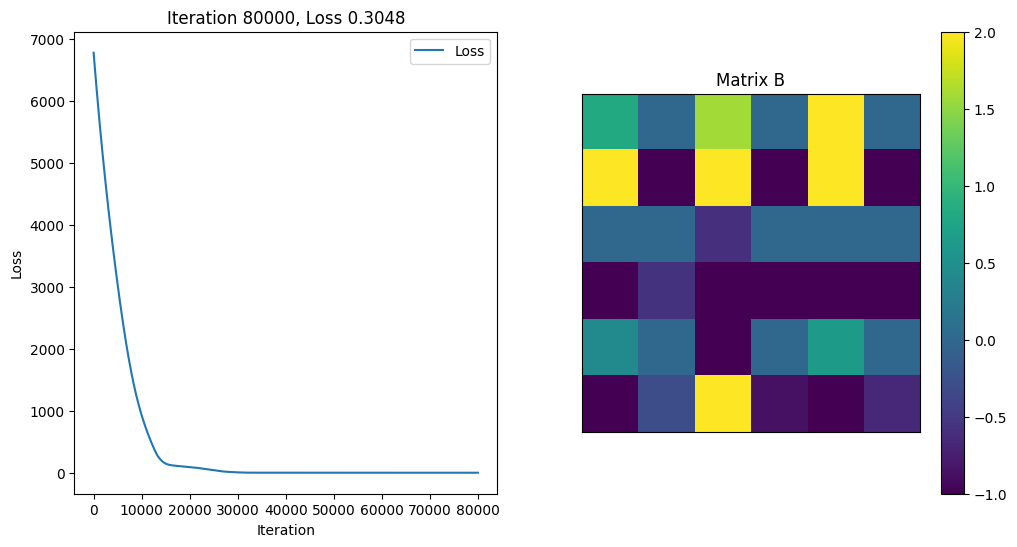

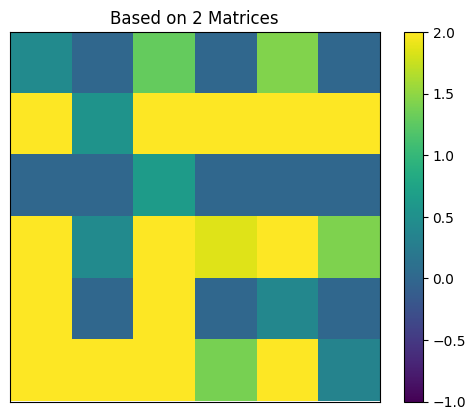

In [ ]:
# Number of sims
N = 2
learning_rate = 1e-3
iterations = 80_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

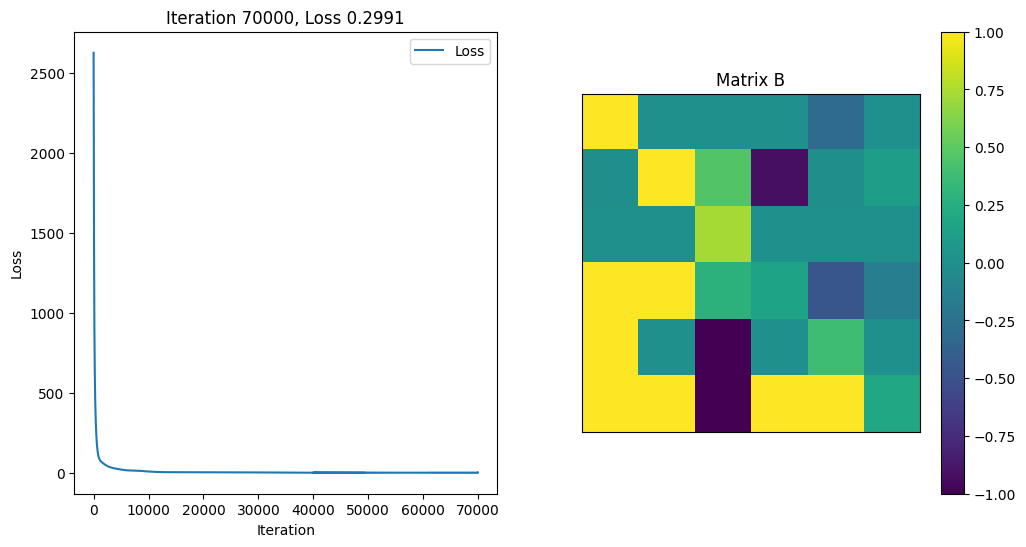

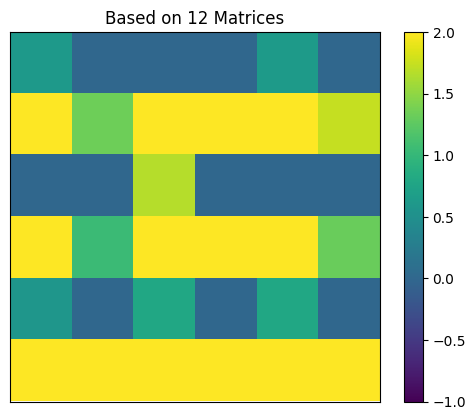

In [ ]:
# Add b[1,3] to zero list
# Number of sims
N = 12
learning_rate = 8e-4
iterations = 70_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3)             ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0), (1,3,5,0,1,3,4,5,1,3,5,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Also set b[1,1]=0 using b[1,5]!=0

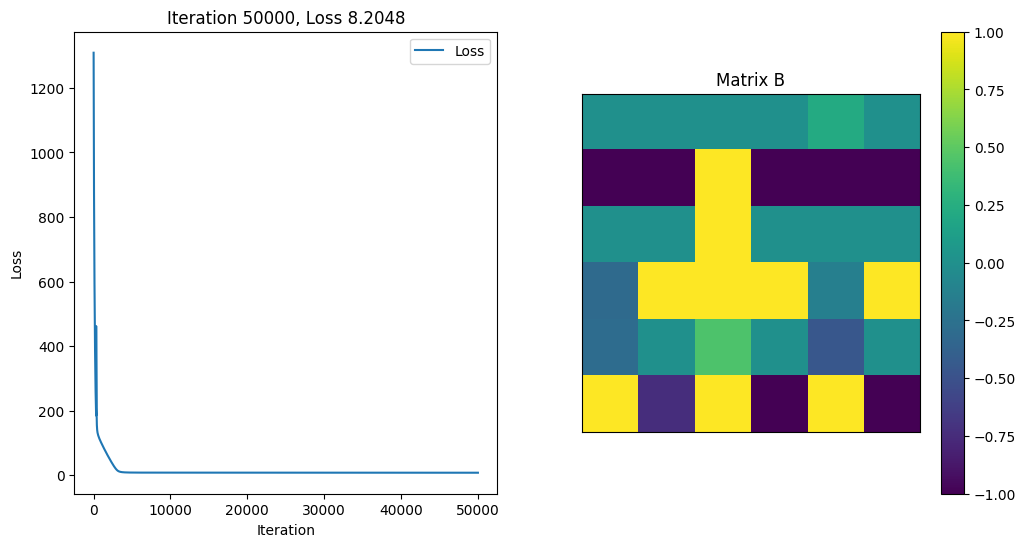

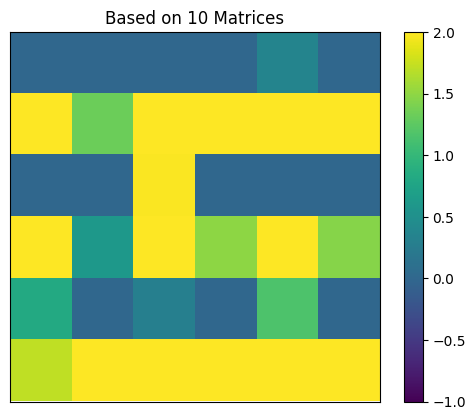

In [ ]:
# Add b[1,1] to zero list
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 50_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1)            ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0), (1,3,5,0,1,3,4,5,1,3,5,2,0))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

### Assumption b[2,2] != 0
Set b[1,2]=0

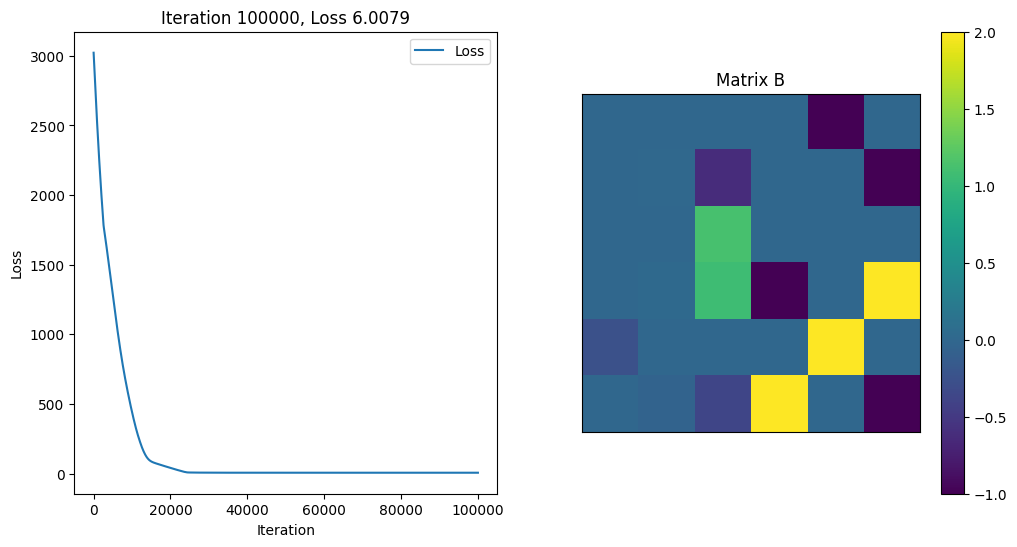

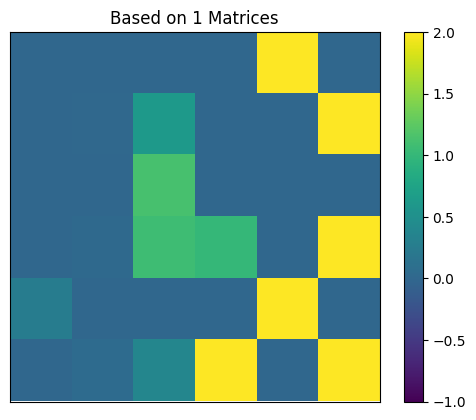

In [ ]:
# Add b[2,1] to zero list
# Number of sims
N = 1
learning_rate = 1e-3
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1), (2,1)            ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0,1), (1,3,5,0,1,3,4,5,1,3,5,2,0,0))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Also set b[2,3]=0

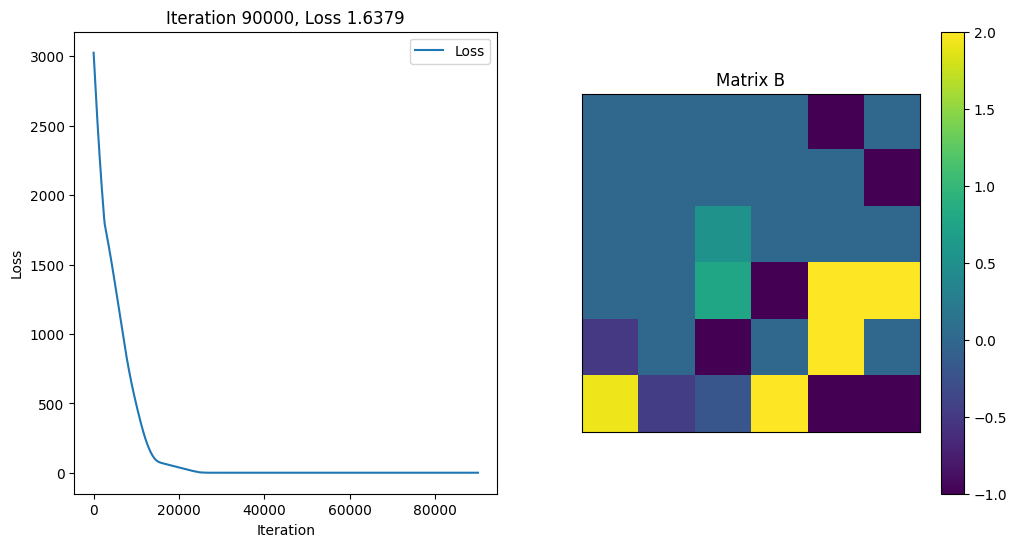

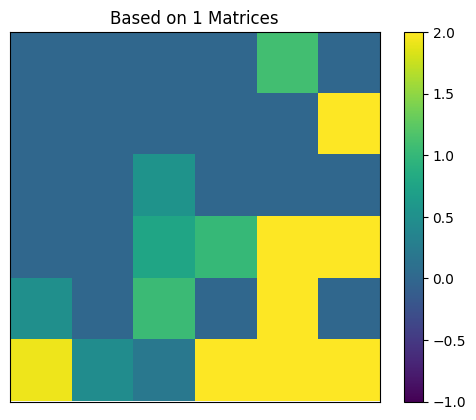

In [ ]:
# Add b[2,3] to zero list
# Number of sims
N = 1
learning_rate = 1e-3
iterations = 90_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([(1,2), (1,4), (1,6),
#                       (3,1), (3,2), (3,4), (3,5), (3,6),
#                       (5,2), (5,4), (5,6),
#                       (1,3), (1,1), (2,1), (2,3)        ])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,0,1,1), (1,3,5,0,1,3,4,5,1,3,5,2,0,0,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

# Finding B Matrix Heat Eq Using Cutoff ADAM and Norm

In [ ]:
N_gen = 6

# Construct structure constant matrices, also taking the (duplicate) structure constants into account
c_heat = jnp.zeros((N_gen,N_gen,N_gen))

# regular values   (same generator order as in R. J. Gray)
c_heat = c_heat.at[3,0,0].set(1)
c_heat = c_heat.at[4,3,4].set(1)
c_heat = c_heat.at[4,0,2].set(-1)

c_heat = c_heat.at[5,0,4].set(2)
c_heat = c_heat.at[3,1,1].set(2)
c_heat = c_heat.at[4,1,0].set(2)
c_heat = c_heat.at[5,3,5].set(2)

c_heat = c_heat.at[5,1,2].set(-2)
c_heat = c_heat.at[5,1,3].set(4)

# reverse values
c_heat = c_heat.at[0,3,0].set(-1)
c_heat = c_heat.at[3,4,4].set(-1)
c_heat = c_heat.at[0,4,2].set(1)

c_heat = c_heat.at[0,5,4].set(-2)
c_heat = c_heat.at[1,3,1].set(-2)
c_heat = c_heat.at[1,4,0].set(-2)
c_heat = c_heat.at[3,5,5].set(-2)

c_heat = c_heat.at[1,5,2].set(2)
c_heat = c_heat.at[1,5,3].set(-4)

In [ ]:
# Function that plots averaged B matrix, returns nothing
def matrix_plotter(B_sum, zero_determinant_counter):
  plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
  plt.colorbar()
  plt.title(f"Based on {N - zero_determinant_counter} Matrices")
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
cutoff = .1

# One large functions which can be reused easily for multiple iterations
def matrix_finder(N, l_rate, iters, idx_positions, idx_vals):

  # Create list to store final B matrices in
  B_list = np.zeros((N, N_gen, N_gen))
  zero_determinant_counter = 0

  # Keep already known values of B constant
  @jit
  def keep_constant(B, indices):
    B = B.at[indices].set(y)
    return B

  # condition on B
  def condition_on_B(B):
    lhs = jnp.einsum("mln,il,jm->nij",c_heat,B,B)
    rhs = jnp.einsum("jik,kn->nij",c_heat,B)
    return lhs - rhs

  # zero determinant condition
  def zero_determinant(B, sig):
    det = jnp.linalg.det(B)
    res = jnp.exp(-0.5*((det/sig)**2)) / sig
    return res

  # loss function to be optimized, using frobenius norm
  @jit
  def loss(B):
    return jnp.sqrt(jnp.sum(condition_on_B(B)**2)) + 1*zero_determinant(B, 1e-1)

  # Use the grad function from jax
  grad_loss = jit(grad(loss))

  for idx in range(N):
    # Use key to generate random values for initial guess
    key = random.key(idx)
    B_init = 10*random.normal(key, (N_gen,N_gen))

    # Set starting B matrix
    B = B_init
    B = keep_constant(B, zero_list)
    print(B)

    loss_values = []

    # Use ADAM Solver
    solver = optax.adam(l_rate)
    params = B_init
    opt_state = solver.init(params)

    for iter in range(iterations):
      grad_adam = grad_loss(params)
      updates, opt_state = solver.update(grad_adam, opt_state, params)

      params = optax.apply_updates(params, updates)
      params = keep_constant(params, zero_list)

      param_loss = loss(params)
      loss_values.append(loss(params))

      if param_loss < cutoff:
        break


    clear_output(wait=True)

    # Use final result as B matrix
    B = params
    last_loss = loss(B)

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Iteration {len(loss_values)}, Loss {last_loss:.4f}')

    # Showing the matrix B
    plt.subplot(1, 2, 2)
    plt.imshow(B, cmap='viridis', vmin=-1, vmax=2)
    plt.colorbar()
    plt.title('Matrix B')
    plt.xticks([])
    plt.yticks([])

    display(plt.gcf())
    plt.close()

    if last_loss < cutoff*10:
      B_list[idx] = B
    else:
      zero_determinant_counter +=1


  B_sum = jnp.sum(jnp.abs(B_list), axis=0) / (N - zero_determinant_counter)

  return B_sum, zero_determinant_counter

Testing to see what happens for first gen

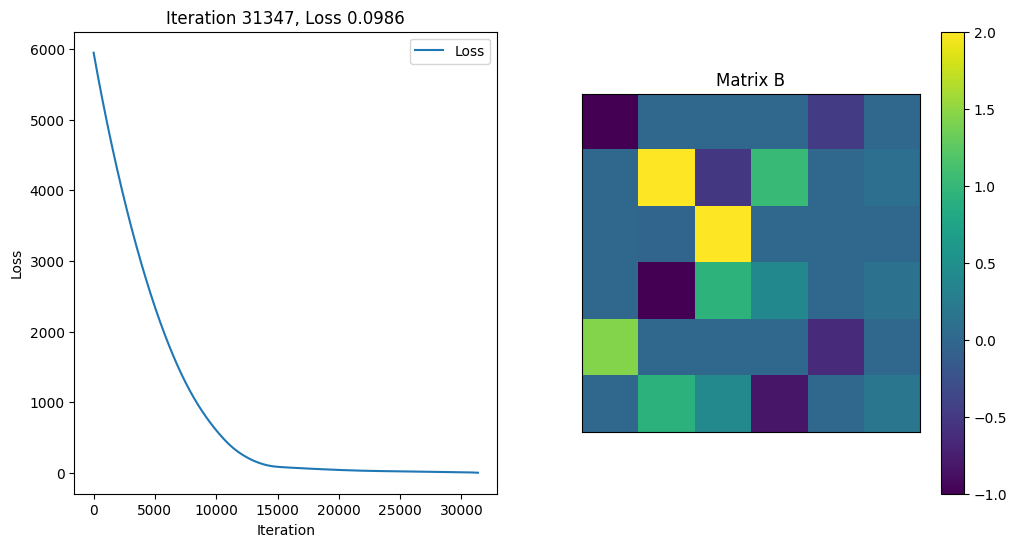

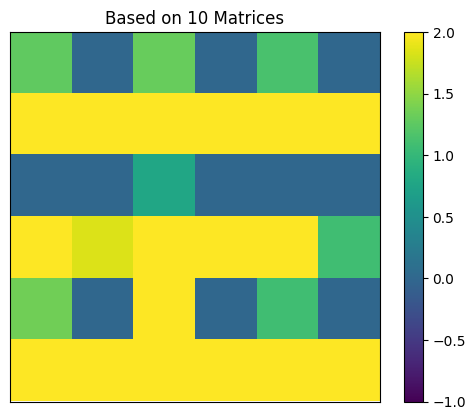

In [ ]:
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((), ())
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

([], [])

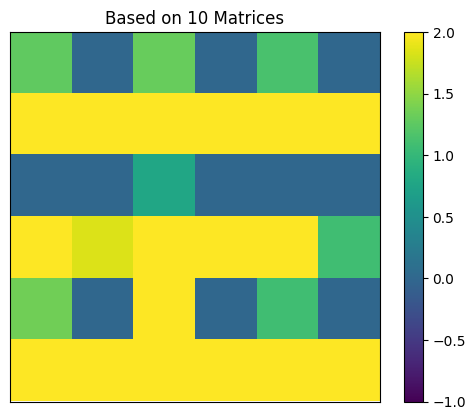

In [ ]:
plt.imshow(B_sum, cmap='viridis', vmin=-1, vmax=2)
plt.colorbar()
plt.title(f"Based on {N - zero_determinant_counter} Matrices")
plt.xticks([])
plt.yticks([])
#plt.savefig("heat-noadj-adam-cutoff0.1-n10-l1e3-i100_000.jpg",bbox_inches='tight')
#plt.savefig("heat-noadj-adam-cutoff0.1-n10-l1e3-i100_000.pdf",bbox_inches='tight')
#plt.show()

## Assumption b[1,5] = 0

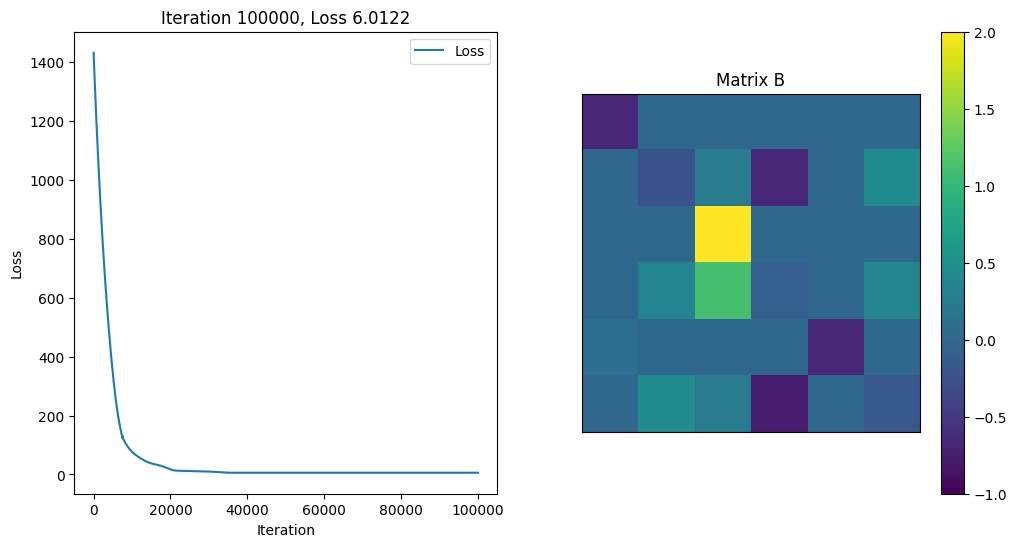

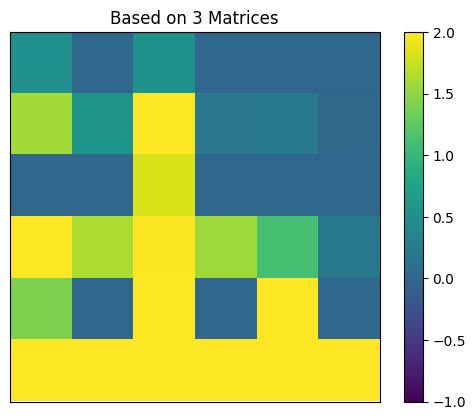

In [ ]:
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 100_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0), (1,3,5,0,1,3,4,5,1,3,5,4))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

### Assumption b[1,1] != 0
sets b[1,3] = 0 using m5

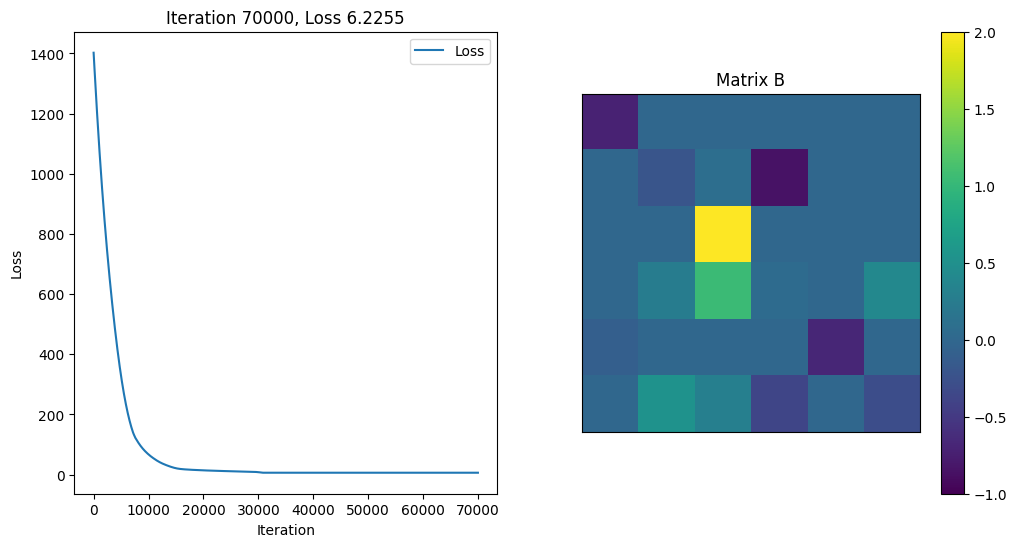

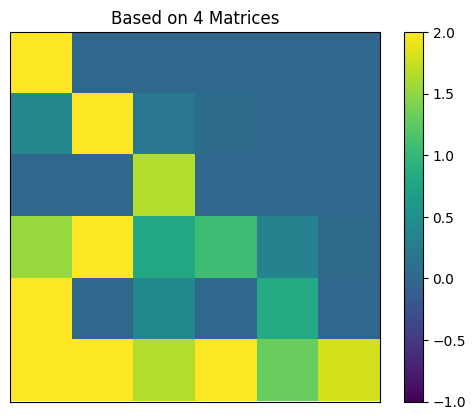

In [ ]:
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 70_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,1,0), (1,3,5,0,1,3,4,5,1,3,5,4,5,2))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

JAX gives b[2,5] = 0 and b[4,6]=0 <br>
Set b[6,5] = 0 using matrix 1


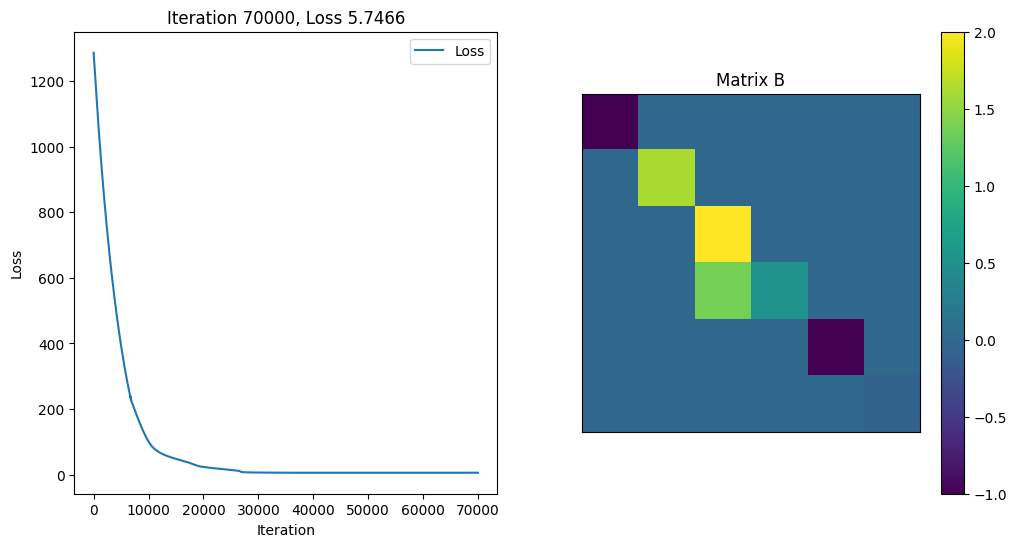

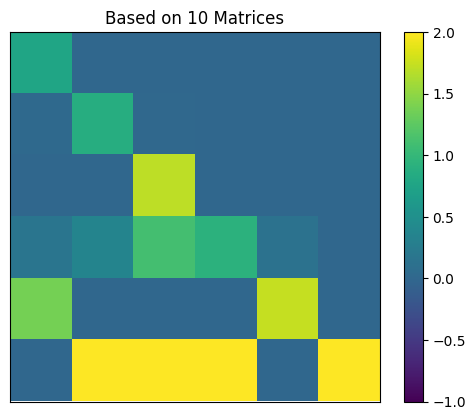

In [ ]:
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 70_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,1,0,1,3,5), (1,3,5,0,1,3,4,5,1,3,5,4,5,2,4,5,4))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

JAX gives b[2,1] = 0, b[2,3]= 0, b[2,4]=0, b[5,3]=0, b[6,1]=0 <br>
Set b[6,4] = 0 using m2

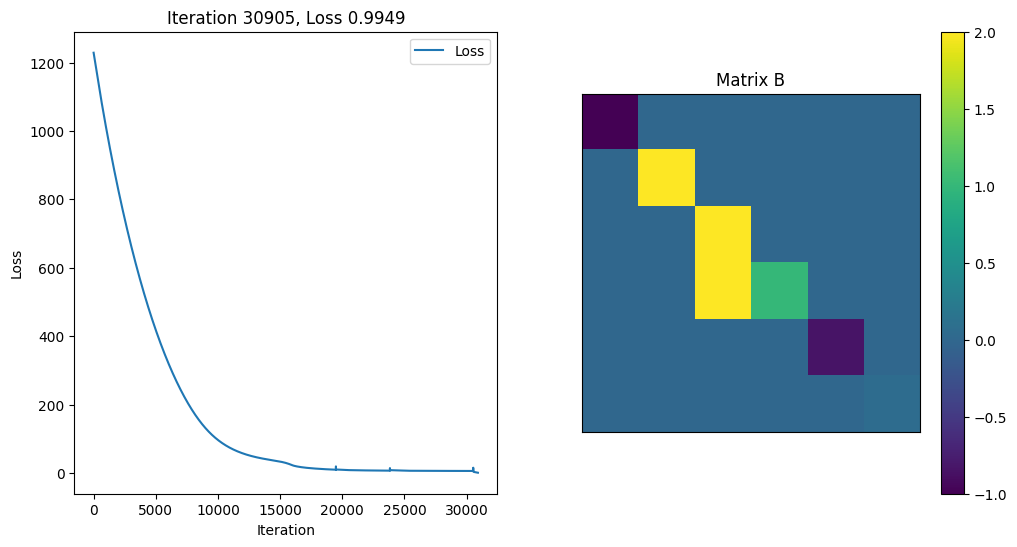

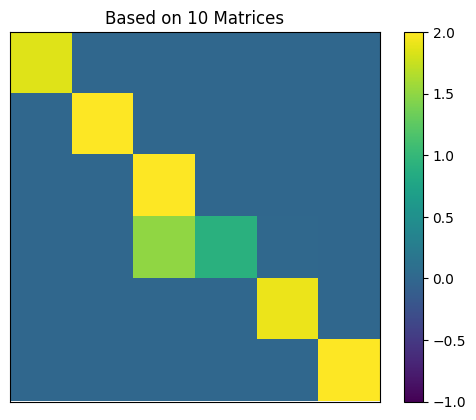

In [ ]:
# Number of sims
N = 10
learning_rate = 1e-3
iterations = 70_000

# List of indices of which the value of B matrix is known to be zero
#zero_list = jnp.array([])

# Tuple of rows and columns of each known zero entry
zero_list = ((0,0,0,2,2,2,2,2,4,4,4,0,1,0,1,3,5,1,1,1,4,5,5), (1,3,5,0,1,3,4,5,1,3,5,4,5,2,4,5,4,0,2,3,2,0,3))
y = np.array([0 for _ in range(len(zero_list[0]))])

# Call the function with all the right parameters
B_sum, zero_determinant_counter = matrix_finder(N, learning_rate, iterations, zero_list, y)

# Display output
matrix_plotter(B_sum, zero_determinant_counter)

Gives b[4,1:2]=0, b[4,5]=0, b[5,1]=0, b[6,2:3]=0 <br>
Matrix 4/6 does not lead to removal of another value, thus fill it into the constraints

# TODO & Meetings

In [ ]:
# TODO: SAGE implementeren in plaats van mathematica?
# Kijken naar Multi-Task Learning (MLT) (mogelijk 2 verschillende gradients in plaats van loss function een som van 2 functies te laten zijn) ook wel gradient combination genoemd
#

In [ ]:
# behandelen in meeting Jelle
# det() heeft nu nul gradient
# Proberen continue functie

# noise toevoegen voor vinden global minima?
# Hoeveel noise toevoegen?
# Optimizer met noise gebruiken?

# anders det()=1 zetten in elke iteratie door rows te multiplyen met constante

# Start met de